# Patterns in Performance: Clustering High School Student Math Course Data

**Names**: Aleksandra Grigortsuk, Wendy Zheng, Yinglei Wu, Xiangrui Deng

## 1. Introduction

Education plays an important role in shaping individuals as well as our societies, shaping students' personal growth in academic and emotional intelligence. Schools aim to measure academic intelligence, grades indicating the measure of acheivement, dedication, and understanding. But not everyone has the equal opportunity to get good grades. By looking at a dataset of Portuguese high school demographics and math course performance, we aim to idenfity through clustering leading factors that could negatively impact a student's final grades. Through the insight we gain by clustering, we can make more informed decisions about teaching and offering help to students who face specific challenges that may or may not be in the student's control. 

Citations:
* https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics/
* https://arxiv.org/ftp/arxiv/papers/2301/2301.03421.pdf
* https://builtin.com/data-science/data-clustering-python


## 2. Dataset Discussion

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from gower import gower_matrix

from scipy.spatial.distance import pdist, squareform
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('student_math_clean.csv')
df.head(5)

student_id school sex  age address_type              family_size  \
0           1     GP   F   18        Urban           Greater than 3   
1           2     GP   F   17        Urban           Greater than 3   
2           3     GP   F   15        Urban  Less than or equal to 3   
3           4     GP   F   15        Urban           Greater than 3   
4           5     GP   F   16        Urban           Greater than 3   

     parent_status               mother_education  \
0            Apart               higher education   
1  Living together  primary education (4th grade)   
2  Living together  primary education (4th grade)   
3  Living together               higher education   
4  Living together            secondary education   

                father_education mother_job  ... family_relationship  \
0               higher education    at_home  ...                   4   
1  primary education (4th grade)    at_home  ...                   5   
2  primary education (4th grade)    at_home  ...                   4   
3               5th to 9th grade     health  ...                   3   
4            secondary education      other  ...                   4   

  free_time social weekday_alcohol weekend_alcohol  health absences grade_1  \
0         3      4               1               1       3        6       5   
1         3      3               1               1       3        4       5   
2         3      2               2               3       3       10       7   
3         2      2               1               1       5        2      15   
4         3      2               1               2       5        4       6   

  grade_2 final_grade  
0       6           6  
1       5           6  
2       8          10  
3      14          15  
4      10          10  

[5 rows x 34 columns]

In [9]:
df.shape[0]

395

In [10]:
df_GP = df[df['school'] == 'GP']
df_GP.shape[0]

349

The dataset was downloaded from Kaggle (https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics), downloaded on November 16, 2023. From the website, the row observations in the dataset represents each students' attribute, i.e. age, sex, internet, etc. This data was collected using school reports and questionnaires, and includes student grades, demographics, social, parent, and school-related features. This dataset contains most of the features that are important in predicting students' grade. However, some feature that might be left out are students' mental health, participation, past-grades, etc. These features might be important in predicting students' grade, and thus, might impact the types of actions that the person in our research motivation might take based on the answer to our research questions. We focus on their math grades and focus only on the school 'GP'. The original dataset has 395 observations, after subsetting school 'GP', there are 349 observations. The variable 'student_id' could be dropped because it's not important for our research goals. The variable we intend to use are 'sex', 'age', 'family_size', 'parents_status', 'mother_education', 'father_education', and many more they have included in the dataset. Most of the variables are categorical. For example, mother_education has categories: higher education, secondary education, etc. And, for binary variables like 'activities' and 'internet_access', they are either yes or no. From those variables, we can further investigate our research questions.

## 3. Dataset Cleaning and Exploration

### Subset the data
1. Only include 'GP' in the school
2. Assign Letter grade to final grade

In [11]:
# Identify Missing values
df_subset = df[df['school'] == 'GP']
quality_map = {'low': 0, 'medium': 1, 'high': 2}

bins = [0,9,13,15,17,20]
labels=['F','C','B','A','A+']
df_subset['letter_grade'] = pd.cut(df_subset['final_grade'], bins=bins, labels=labels, include_lowest=True)

print(df_subset.isnull().any().any())

#df_subset.to_csv("../../letter_grade.csv")

False


In [12]:
df_subset.head(5)

student_id school sex  age address_type              family_size  \
0           1     GP   F   18        Urban           Greater than 3   
1           2     GP   F   17        Urban           Greater than 3   
2           3     GP   F   15        Urban  Less than or equal to 3   
3           4     GP   F   15        Urban           Greater than 3   
4           5     GP   F   16        Urban           Greater than 3   

     parent_status               mother_education  \
0            Apart               higher education   
1  Living together  primary education (4th grade)   
2  Living together  primary education (4th grade)   
3  Living together               higher education   
4  Living together            secondary education   

                father_education mother_job  ... free_time social  \
0               higher education    at_home  ...         3      4   
1  primary education (4th grade)    at_home  ...         3      3   
2  primary education (4th grade)    at_home  ...         3      2   
3               5th to 9th grade     health  ...         2      2   
4            secondary education      other  ...         3      2   

  weekday_alcohol weekend_alcohol health  absences grade_1 grade_2  \
0               1               1      3         6       5       6   
1               1               1      3         4       5       5   
2               2               3      3        10       7       8   
3               1               1      5         2      15      14   
4               1               2      5         4       6      10   

  final_grade letter_grade  
0           6            F  
1           6            F  
2          10            C  
3          15            B  
4          10            C  

[5 rows x 35 columns]

In [17]:
df_cat=df_subset.copy().drop(['letter_grade', 'final_grade','school', 'student_id', 'absences', 'grade_1', 'grade_2'], axis=1)
df_cat.head()

X_cat = df_cat.copy()

from sklearn import preprocessing

label_enc = {}
for col in df_cat.columns:
    label_enc[col] = preprocessing.LabelEncoder()
    print(col)
    X_cat[col] = label_enc[col].fit_transform(df_cat[col])

dist_mat = squareform(pdist(X_cat, metric='hamming'))

sex
age
address_type
family_size
parent_status
mother_education
father_education
mother_job
father_job
school_choice_reason
guardian
travel_time
study_time
class_failures
school_support
family_support
extra_paid_classes
activities
nursery_school
higher_ed
internet_access
romantic_relationship
family_relationship
free_time
social
weekday_alcohol
weekend_alcohol
health


### Missing Values Results 
1. As is indicated in the answer above, there are no missing values in this particular dataset. 

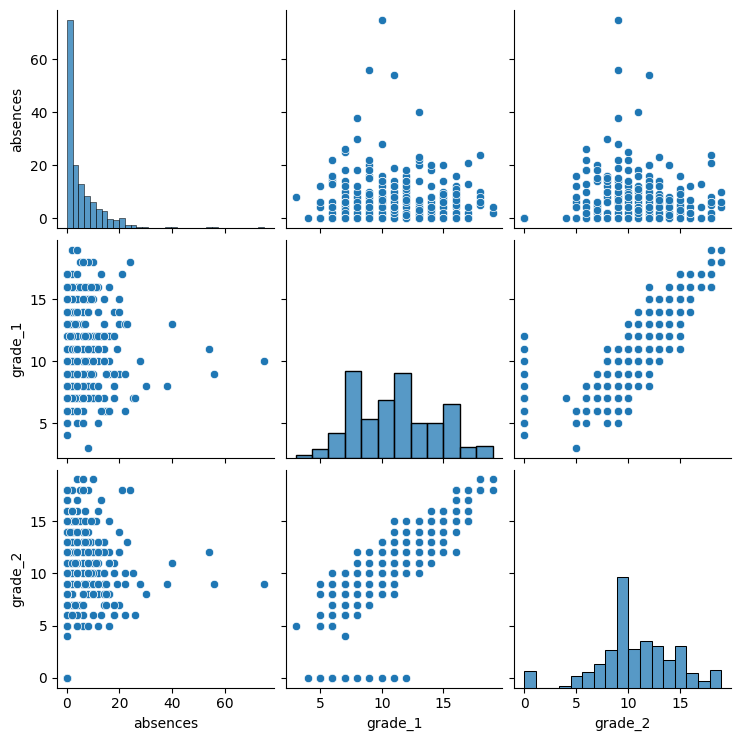

In [18]:
# Now, we would like to create a pair plot on all the numerical variables
df_numerical = df_subset[['absences','grade_1','grade_2']]
sns.pairplot(data=df_numerical)

In [27]:
from sklearn.preprocessing import StandardScaler


X_numeric = df_subset[['absences','grade_1','grade_2']]


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

X_total = pd.concat([X_cat, X_scaled], axis=1)

### Pairwise Scatterplot Results
1. Because most of the numerical values only have interger values, the pairplots between two variables are grids. 
2. It seems that there are not significant outliers in most of the variables except for absences and grades. A few outliers exist with high values (over 40) of absences. 

### Dendrograms for Outlier Detection

Next, we would like to detect high-dimensional outliers with single-linkage dendrograms. The single-linkage dendrogram algorithm is more likely to detect outliers than the average-linkage or complete-linkage algorithms.


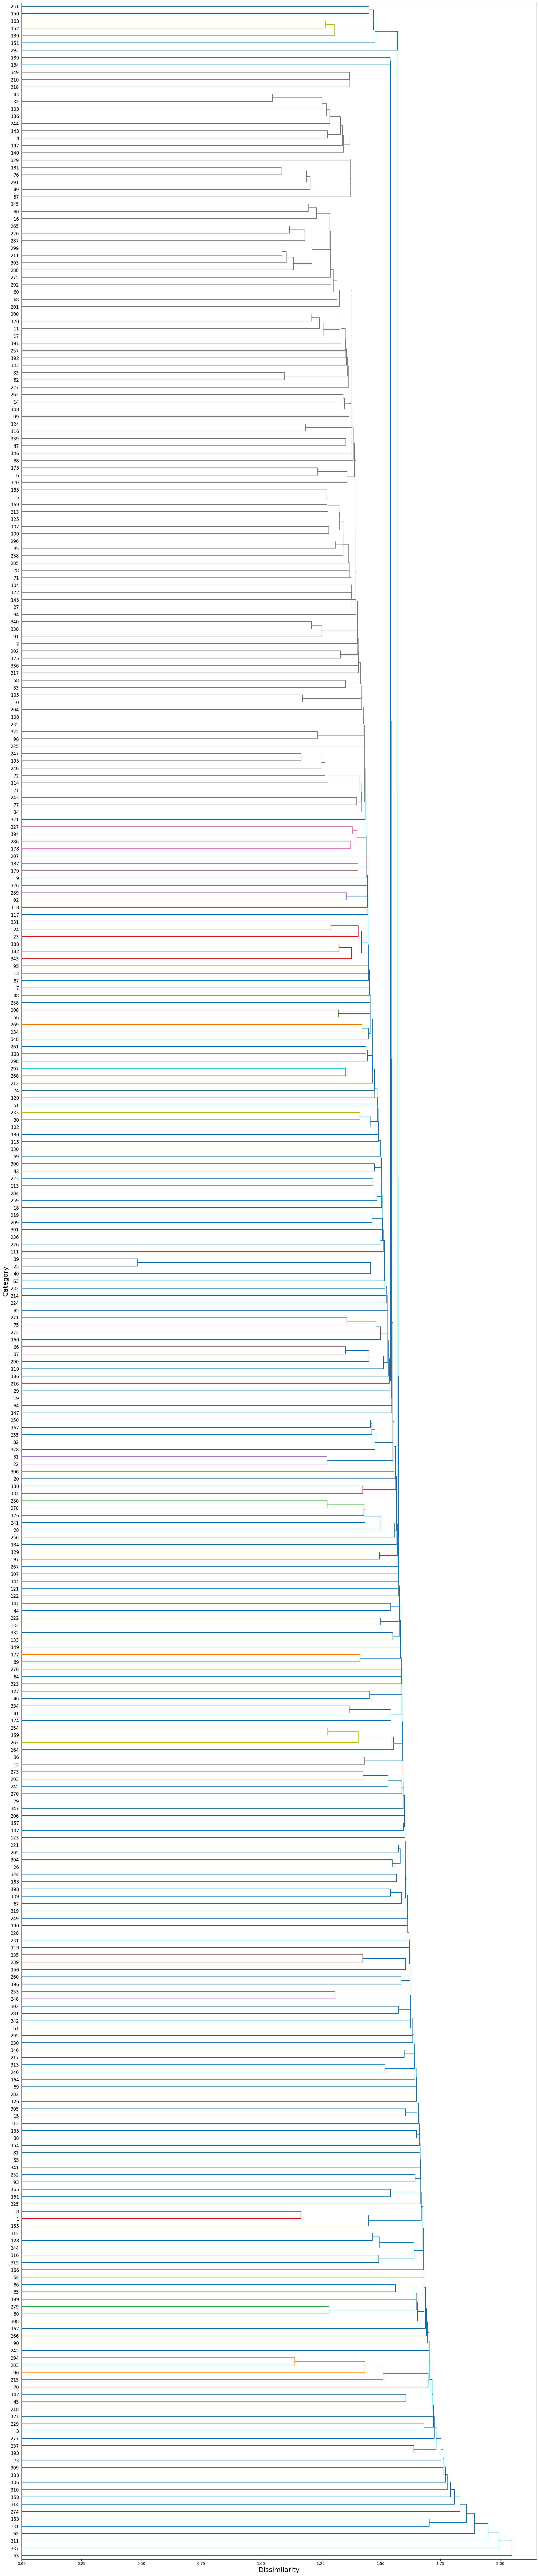

In [28]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

dm = pdist(dist_mat, metric='euclidean')
Z = linkage(dm, method='single')

fig, ax = plt.subplots(figsize=(25, 125))
d = dendrogram(Z, orientation='right', labels=df_subset['student_id'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Category', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

the student with ID **227** forms a singleton cluster, and the students with ID **184** and **75** form another subcluster that's separated from the other observations. We consider these three observations as outliers and will drop them for further analysis.

### Outlier Identification with Single-Linkage Dendrogram Results

According to the dendrogram, some student ids only form small clusters with only 2 or 3 observations in each cluster. We will remove these small clusters as outliers.

#### Explanation

Because our research goal is to cluster students' final grades based on their private information, the three outliers might bias the interpretation of some predictors on the final clustering results. The pros of dropping them is that we can draw general conclusions from the dataset which meets our research goals. However, the cons are that the final clustering algorithms might not be robust as they do not take into account marginal cases.

### Noise Detection
We will first remove the aforementioned outliers and detect noises for the rest of the dataset.

Then, to check for data noises, we plot the k=2, ..., k=9 distance plot

(345, 9)


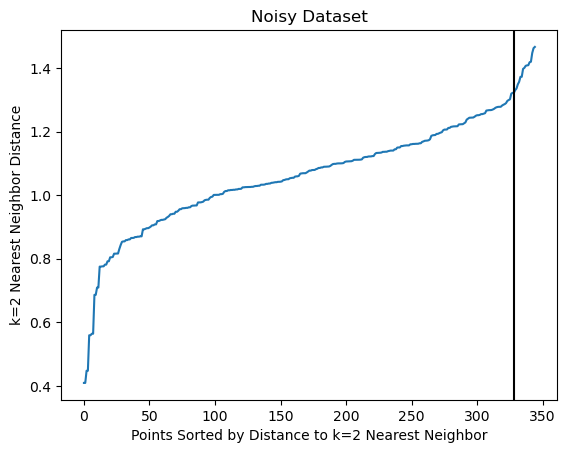

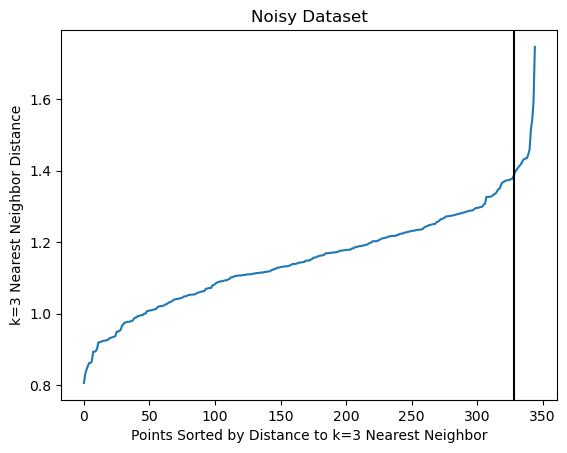

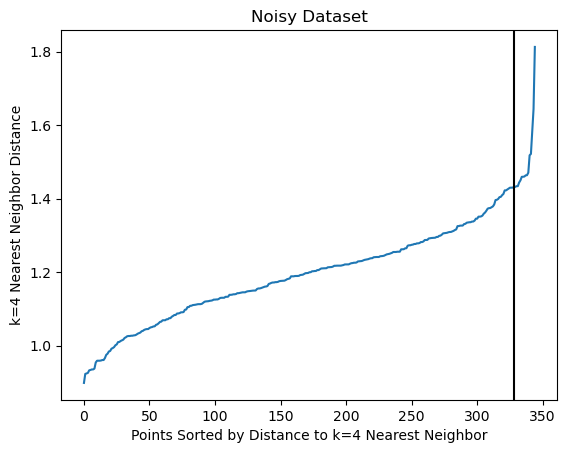

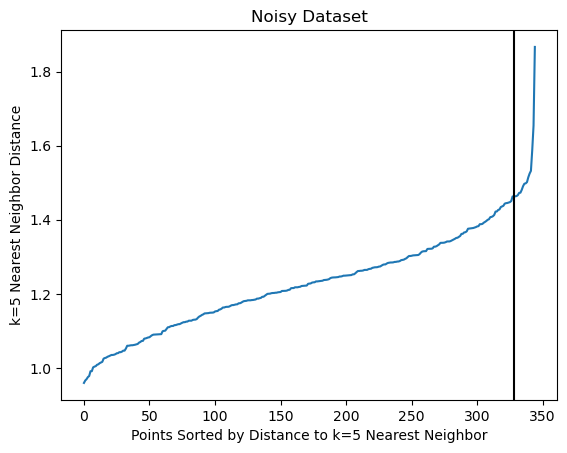

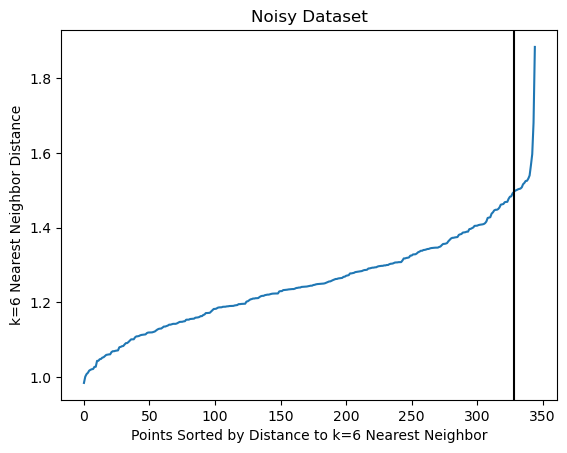

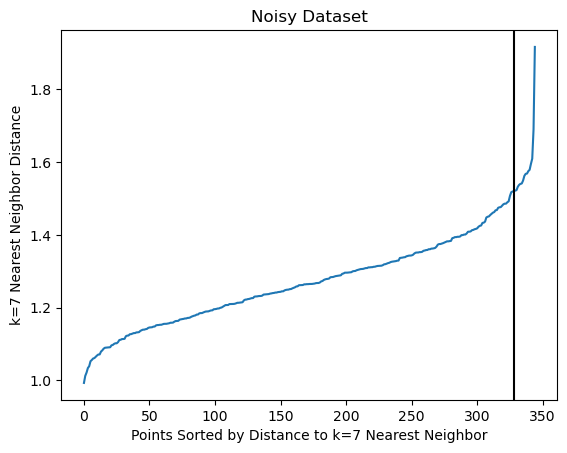

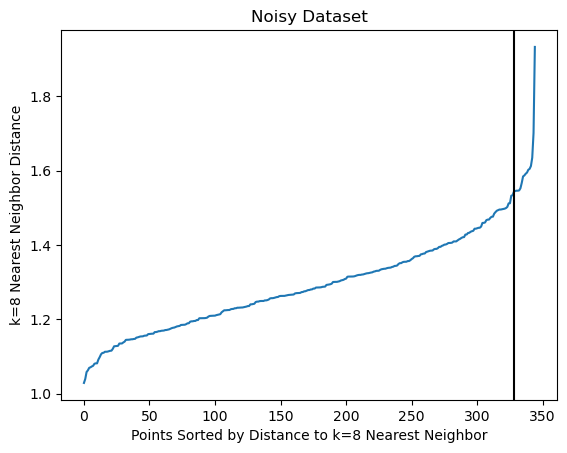

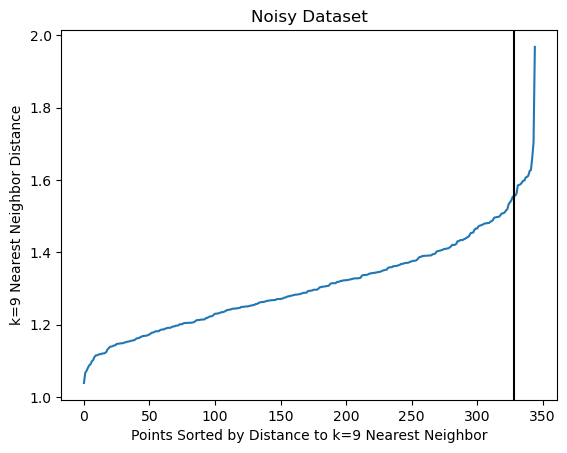

In [24]:
# Filter df
df_subset_outlier_removal = df_subset[~df_subset['student_id'].isin([165, 62, 277, 248])].reset_index()

X_numerical = df_subset_outlier_removal[['age', 'class_failures','family_relationship','free_time', 'social', 'weekday_alcohol','weekend_alcohol','health','absences']]
print(X_numerical.shape)

X_new = df_subset_outlier_removal.copy().drop(['letter_grade', 'final_grade', 'school', 'student_id'], axis=1)
new_dist_mat = gower_matrix(X_new)

from sklearn.neighbors import NearestNeighbors
#Find the distance of the kth nearest neighbor
for k in range(2,10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(new_dist_mat)
    distances, indices = nbrs.kneighbors(new_dist_mat)

    plt.plot(np.sort(distances.T[k-1]))
    plt.axvline(x=328, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

### Noisy Data Conclusion

For k=2...k=9 nearest neighbor plots, there is a dramatic jump in nearest neighbor distances when the number of observations is 328, which indicates that 7 noisy data points exist in the current dataset. Based on the information of noisy data obtained, we can pick reasonable values of $\epsilon$ when using DBSCAN algorithms for clustering. 

* In the k=2-5 nearest neighbors plot, we see that the closest neighbor of the 159 "noise points" is a distance of at least $\epsilon\approx 1.5$ away. Thus, if we were to set $minpts=2$, then we would want to set this $\epsilon\leq  1.5$.
* In the k=6-9 nearest neighbors plot, we see that the closest neighbor of the 159 "noise points" is a distance of at least $\epsilon\approx 1.6$ away. Thus, if we were to set $minpts=4$, then we would want to set this $\epsilon\leq  1.6$. Setting this value less than $\epsilon\leq  1.6$ could create even more noise points and/or more clusters in the dataset.

## 4. Basic Descriptive Analytics

In [25]:
#seperate numerical data 
df_num = df_subset_outlier_removal.select_dtypes(include = ['float64', 'int64'])
#remove "student_id" column
df_num = df_num.drop(['student_id'], axis=1)

#summary of the numerical data
df_num.describe()

index         age  class_failures  family_relationship  \
count  345.000000  345.000000      345.000000           345.000000   
mean   173.849275   16.501449        0.304348             3.950725   
std    101.066122    1.184013        0.709248             0.872983   
min      0.000000   15.000000        0.000000             1.000000   
25%     87.000000   16.000000        0.000000             4.000000   
50%    174.000000   16.000000        0.000000             4.000000   
75%    261.000000   17.000000        0.000000             5.000000   
max    348.000000   20.000000        3.000000             5.000000   

        free_time      social  weekday_alcohol  weekend_alcohol      health  \
count  345.000000  345.000000       345.000000       345.000000  345.000000   
mean     3.223188    3.101449         1.426087         2.240580    3.571014   
std      0.979164    1.109485         0.818331         1.288401    1.377255   
min      1.000000    1.000000         1.000000         1.000000    1.000000   
25%      3.000000    2.000000         1.000000         1.000000    3.000000   
50%      3.000000    3.000000         1.000000         2.000000    4.000000   
75%      4.000000    4.000000         2.000000         3.000000    5.000000   
max      5.000000    5.000000         5.000000         5.000000    5.000000   

         absences     grade_1     grade_2  final_grade  
count  345.000000  345.000000  345.000000   345.000000  
mean     5.753623   10.976812   10.811594    10.510145  
std      7.489927    3.311280    3.820368     4.645645  
min      0.000000    3.000000    0.000000     0.000000  
25%      0.000000    8.000000    9.000000     8.000000  
50%      4.000000   11.000000   11.000000    11.000000  
75%      8.000000   13.000000   13.000000    14.000000  
max     56.000000   19.000000   19.000000    20.000000

In [26]:
#seperate the categorical data
df_cat = df_subset_outlier_removal.select_dtypes(include = ['object'])
df_cat.head()

#summary of the categorical data
df_cat.describe()

school  sex address_type     family_size    parent_status  \
count     345  345          345             345              345   
unique      1    2            2               2                2   
top        GP    F        Urban  Greater than 3  Living together   
freq      345  181          284             249              308   

        mother_education  father_education mother_job father_job  \
count                345               345        345        345   
unique                 5                 5          5          5   
top     higher education  5th to 9th grade      other      other   
freq                 120               102        120        196   

       school_choice_reason  ... travel_time    study_time school_support  \
count                   345  ...         345           345            345   
unique                    4  ...           4             4              2   
top                  course  ...    <15 min.  2 to 5 hours             no   
freq                    122  ...         242           174            295   

       family_support extra_paid_classes activities nursery_school higher_ed  \
count             345                345        345            345       345   
unique              2                  2          2              2         2   
top               yes                 no        yes            yes       yes   
freq              223                184        183            281       331   

       internet_access romantic_relationship  
count              345                   345  
unique               2                     2  
top                yes                    no  
freq               294                   236  

[4 rows x 21 columns]

[('index', 'age'),
 ('age', 'index'),
 ('weekday_alcohol', 'weekend_alcohol'),
 ('weekend_alcohol', 'weekday_alcohol'),
 ('grade_1', 'grade_2'),
 ('grade_1', 'final_grade'),
 ('grade_2', 'grade_1'),
 ('grade_2', 'final_grade'),
 ('final_grade', 'grade_1'),
 ('final_grade', 'grade_2')]

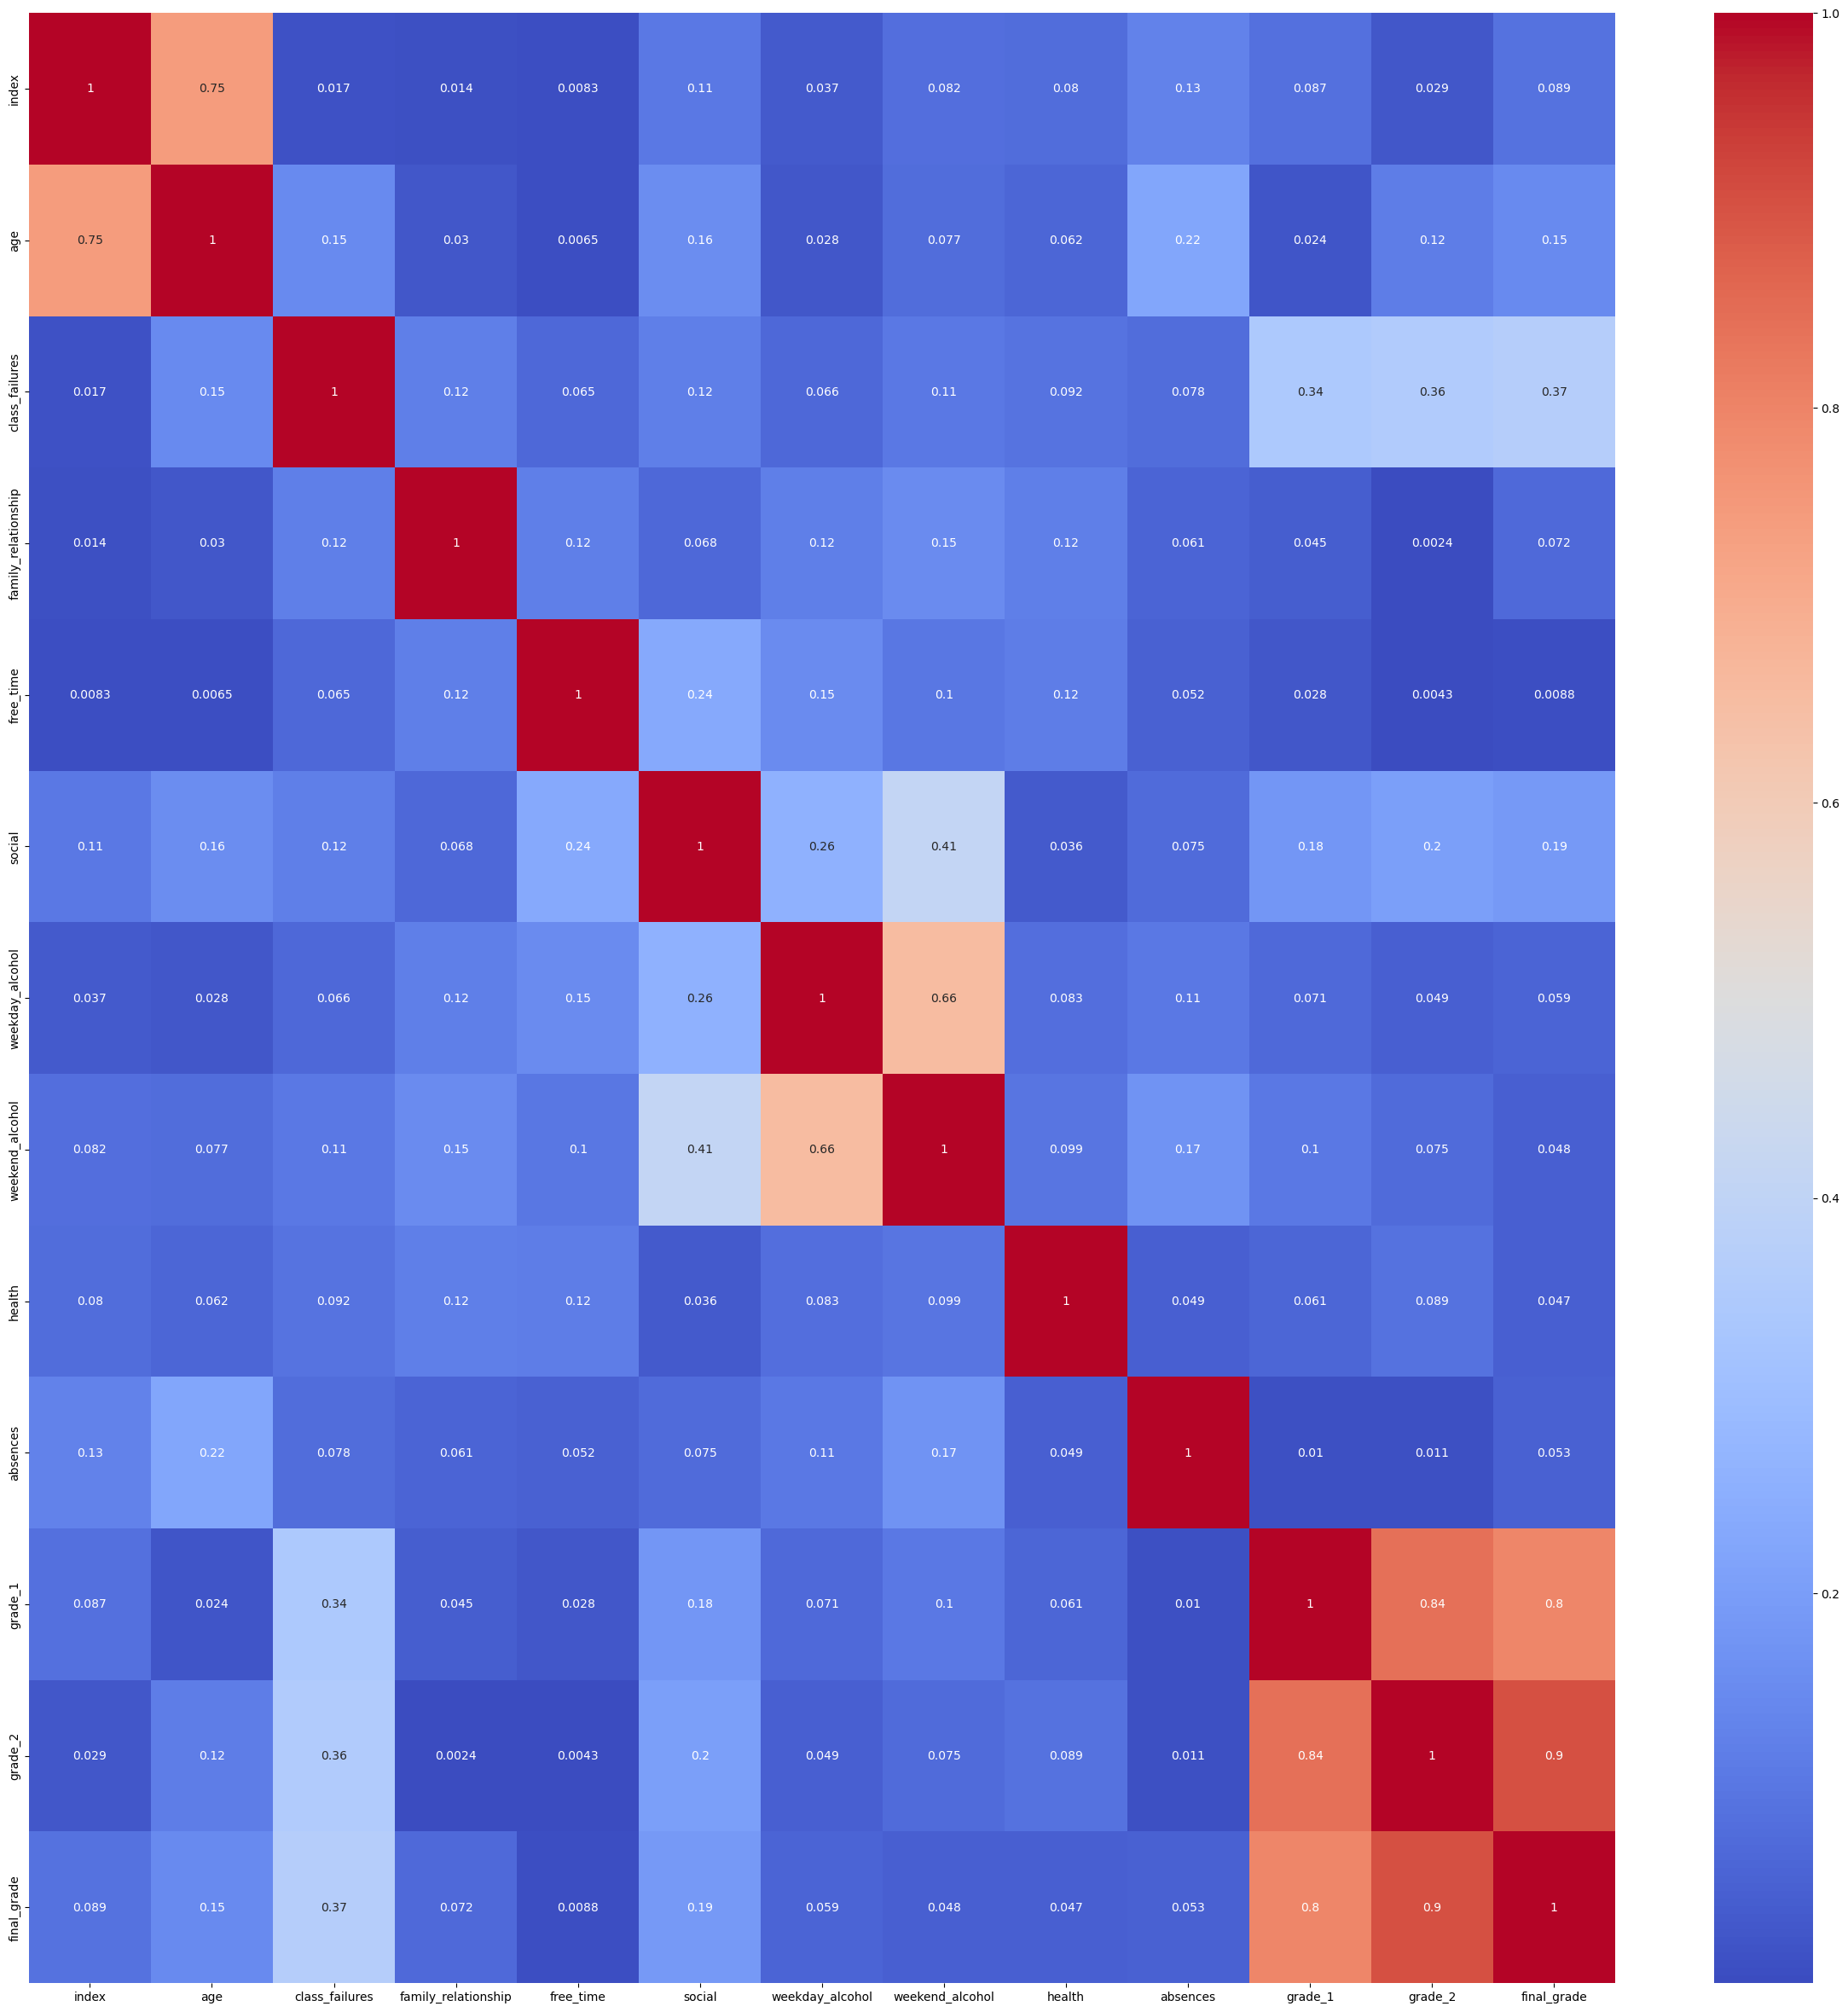

In [27]:
#pairwise correlation of numerical data
df_num_corr = df_num.corr()
df_num_corr

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_corr), annot = True, cmap = 'coolwarm')

high_corr_pairs = [(column, correlated_column) 
                   for column in df_num_corr.columns 
                   for correlated_column in  df_num_corr.columns 
                   if (abs(df_num_corr.loc[column, correlated_column]) > 0.5) and (column != correlated_column)]

high_corr_pairs


Grade 1 is highly correlated with grade 2 and final grade. Alcohol consumption patterns (weekday_alcohol and weekend_alcohol) are also correlated, otherwise there aren't many numerical pairwise correlation.

<Axes: >

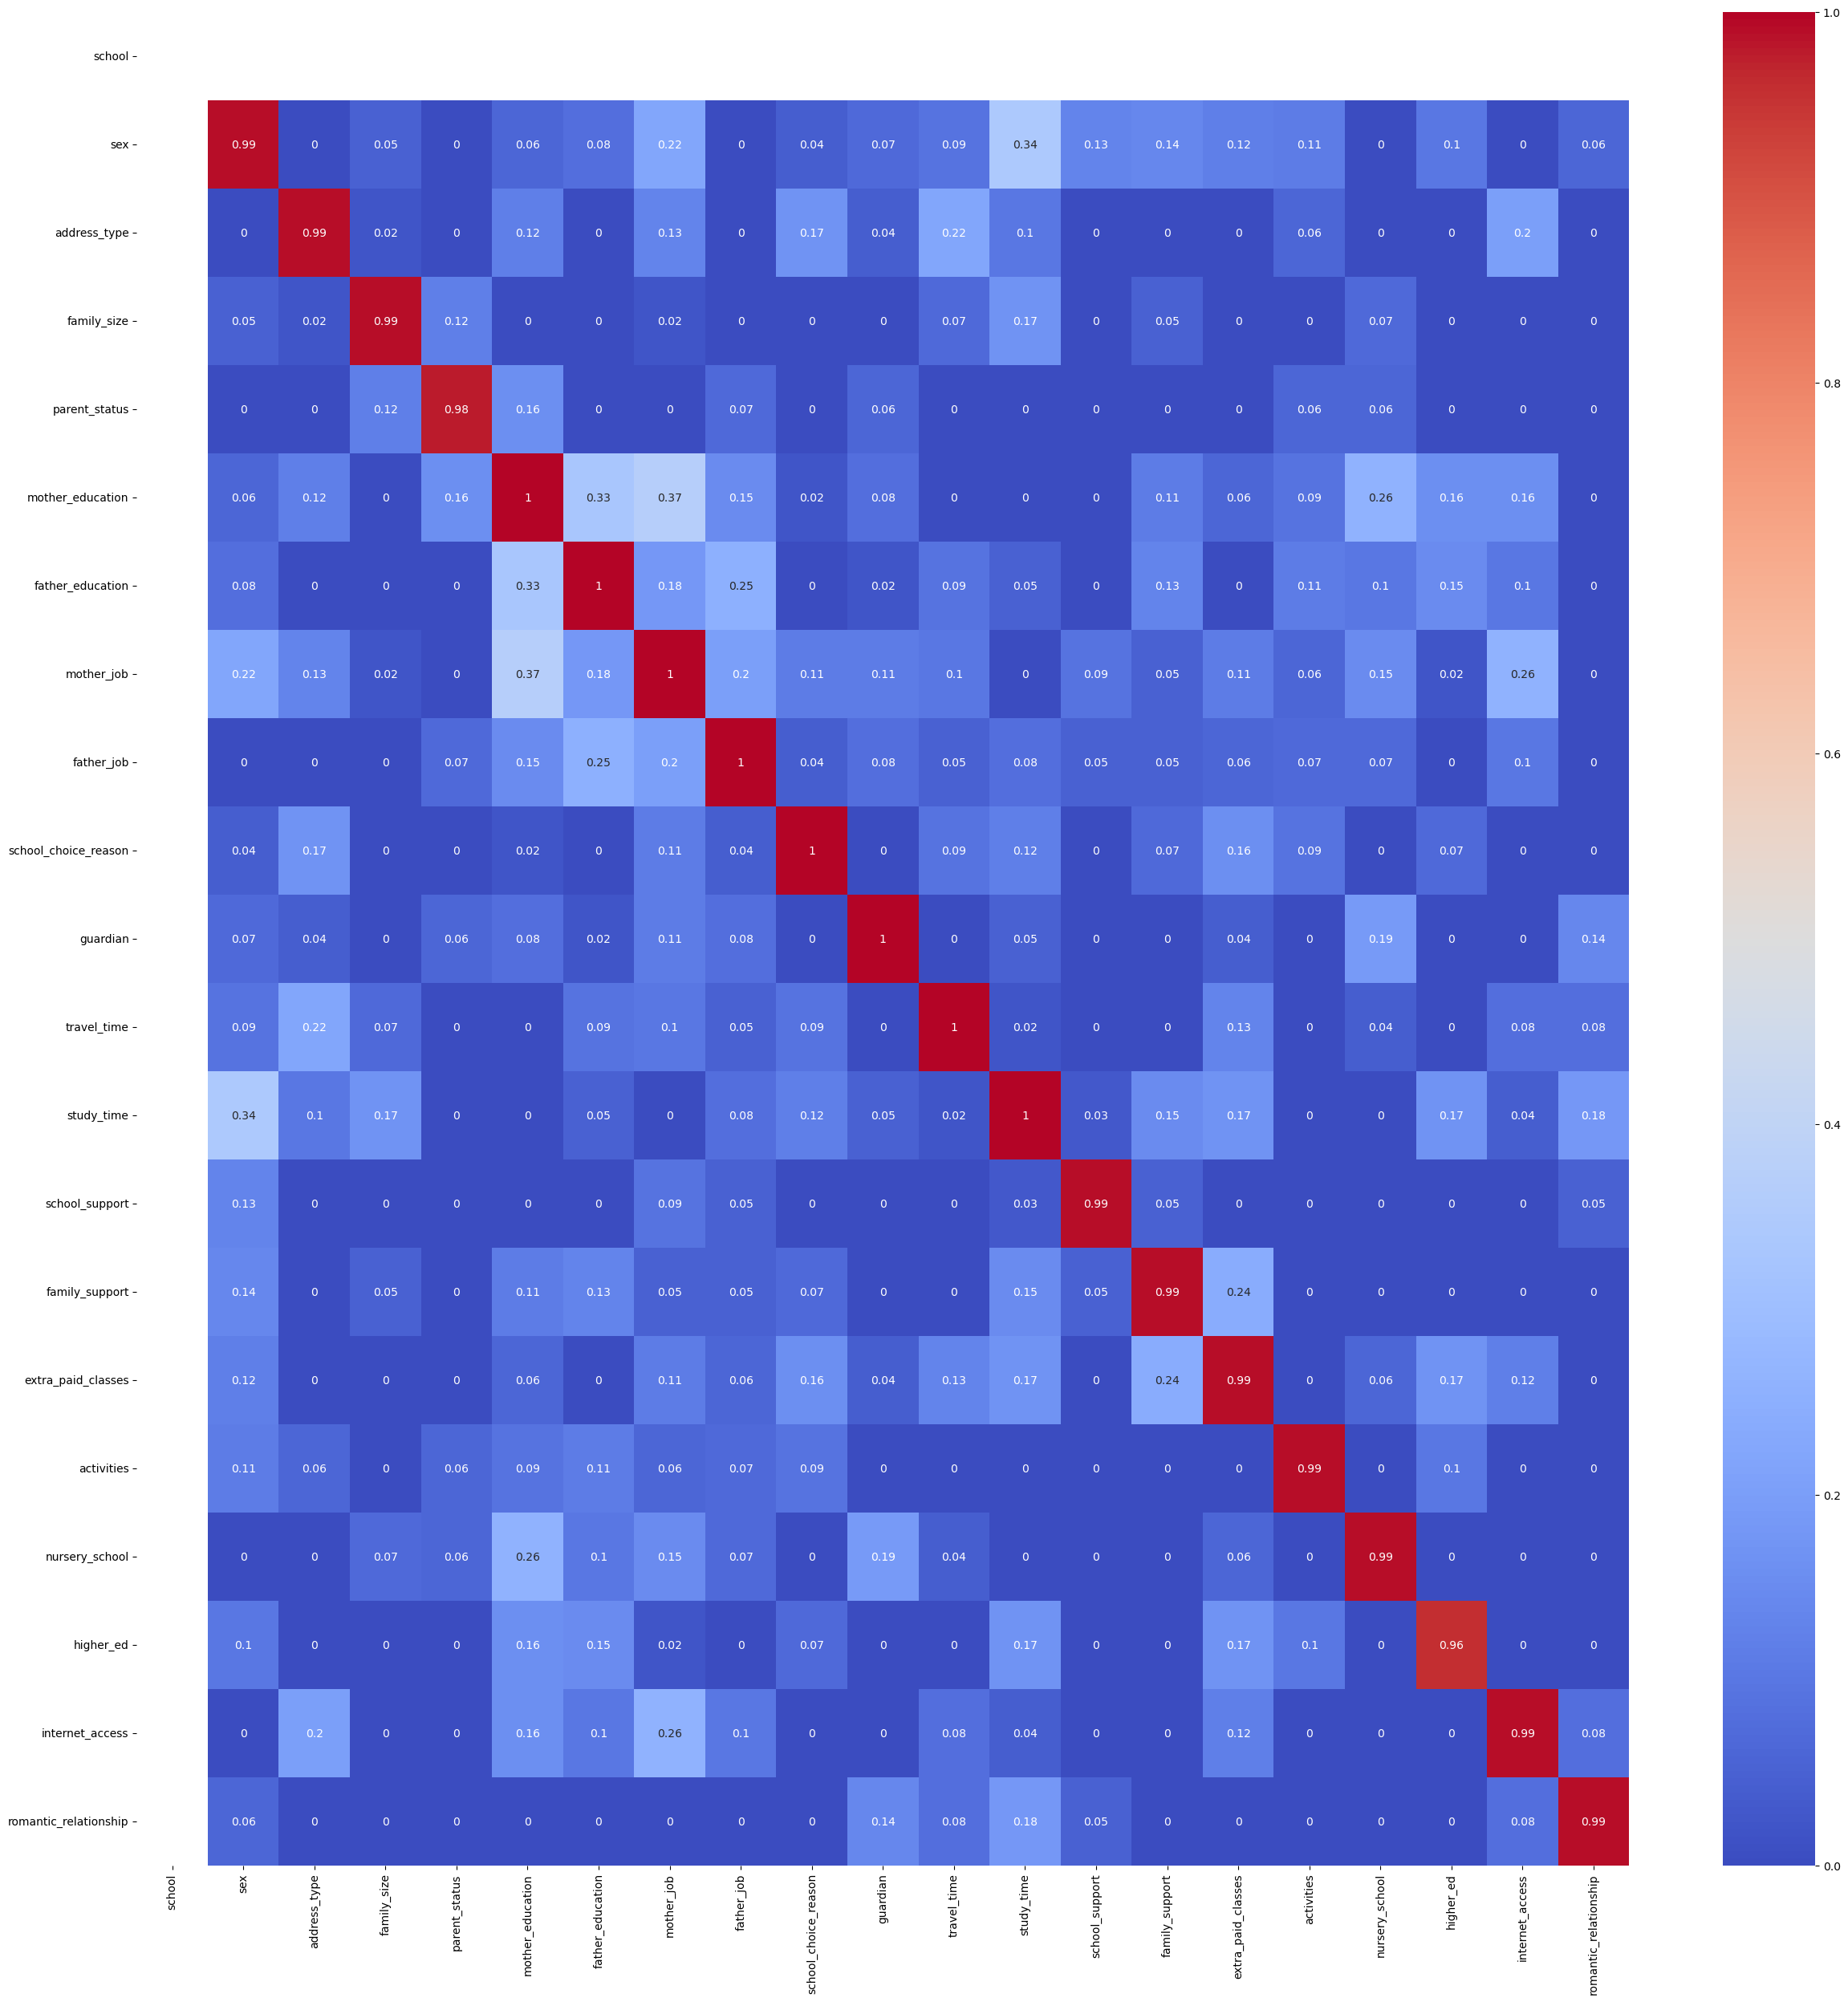

In [28]:
#contingency table for categorical variables
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#pairwise correlation of categorical data
rows= []

for var1 in df_cat:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_cat[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_cat.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_cat_corr), annot = True, cmap = 'coolwarm')



According to the heatmap, the categorical variables does not have significant pairwise correlation.

<Axes: >

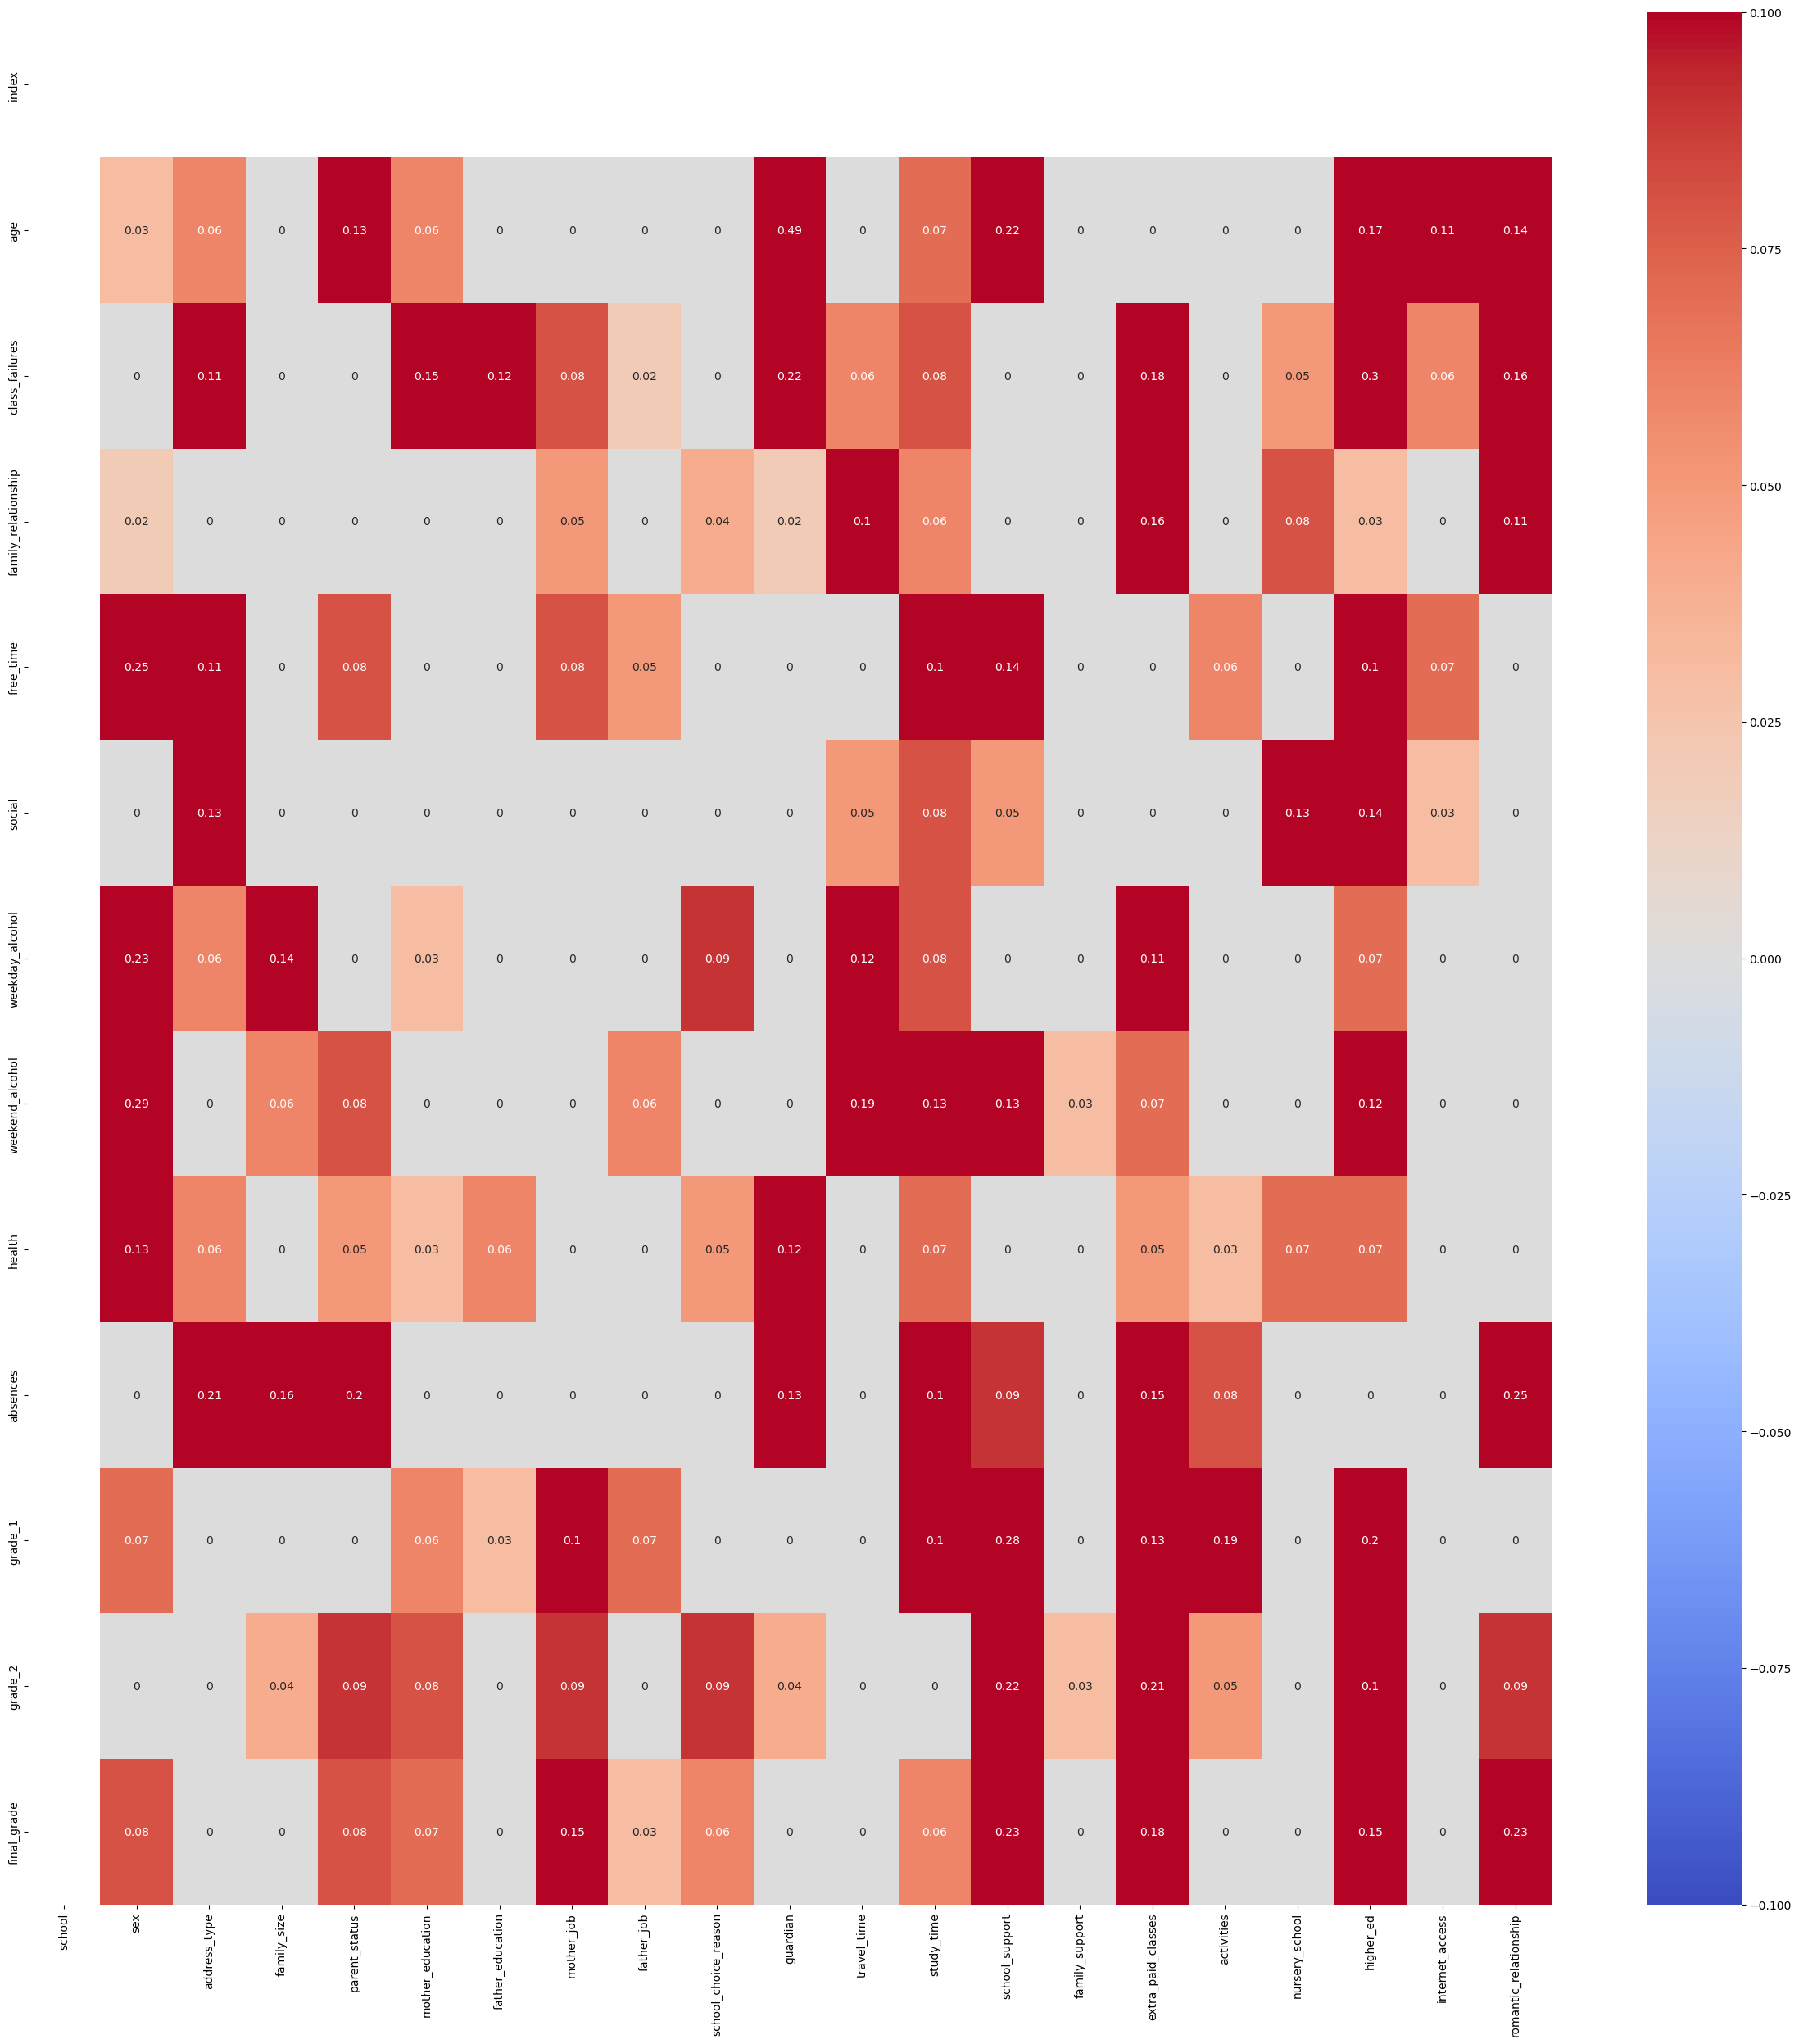

In [29]:
#pairwise relationship between numerical variables and categorical varaiables
rows = []

for var1 in df_num:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_num[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_num_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_num.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_cat_corr), annot = True, cmap = 'coolwarm')


For numerical and categorical variables, we can see that there guardian is correlated with age, but otherwise there's not much correlation between numerical and categorical variables.

In [30]:
df_subset_outlier_removal.shape

(345, 36)

## 5. Scaling Decisions

We want to standardize the dataset, since some features have a higher std that can negatively impact the clustering model results. By scaling the data, it would normalize stds to be lower.

In [19]:
from sklearn.preprocessing import StandardScaler

numeric_columns = df_subset_outlier_removal.select_dtypes(include=['number']).columns
categorical_columns = df_subset_outlier_removal.select_dtypes(exclude=['number']).columns

X_numeric = df_subset_outlier_removal[numeric_columns]
X_categorical = df_subset_outlier_removal[categorical_columns]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

df_scaled = pd.concat([X_scaled, X_categorical], axis=1)


## 6. Clusterability and Clustering Structure

In [20]:
new_dist_mat

array([[0.        , 0.3094216 , 0.4349009 , ..., 0.44273674, 0.3990302 ,
        0.41655153],
       [0.3094216 , 0.        , 0.4586043 , ..., 0.5113806 , 0.45621577,
        0.4424871 ],
       [0.4349009 , 0.4586043 , 0.        , ..., 0.33985966, 0.3271756 ,
        0.19482027],
       ...,
       [0.44273674, 0.5113806 , 0.33985966, ..., 0.        , 0.20346999,
        0.29550377],
       [0.3990302 , 0.45621577, 0.3271756 , ..., 0.20346999, 0.        ,
        0.1826999 ],
       [0.41655153, 0.4424871 , 0.19482027, ..., 0.29550377, 0.1826999 ,
        0.        ]], dtype=float32)

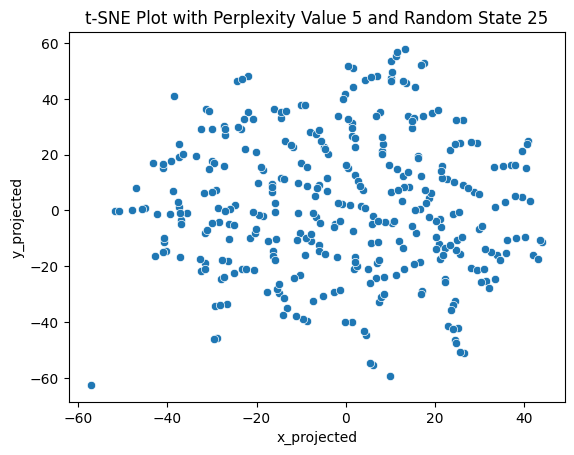

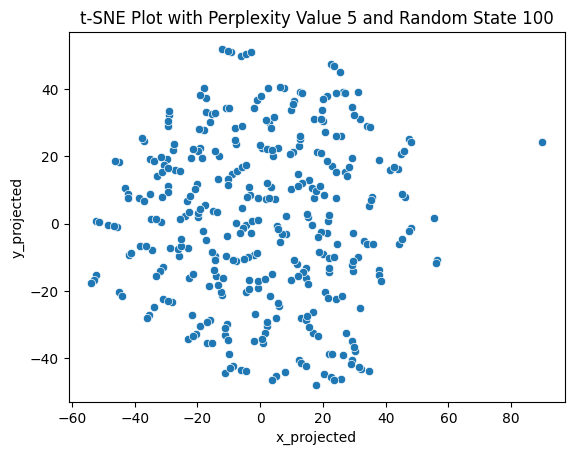

--------------------------------------------


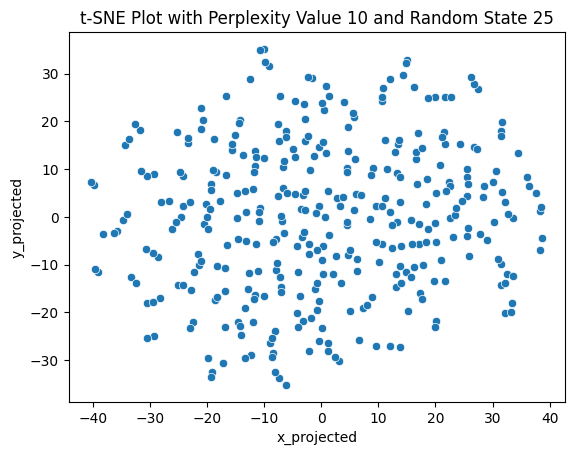

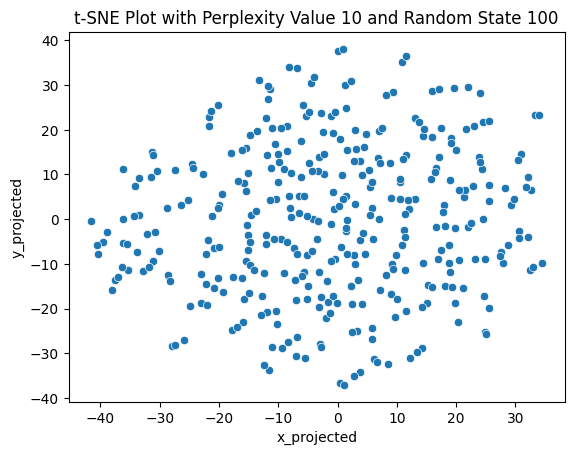

--------------------------------------------


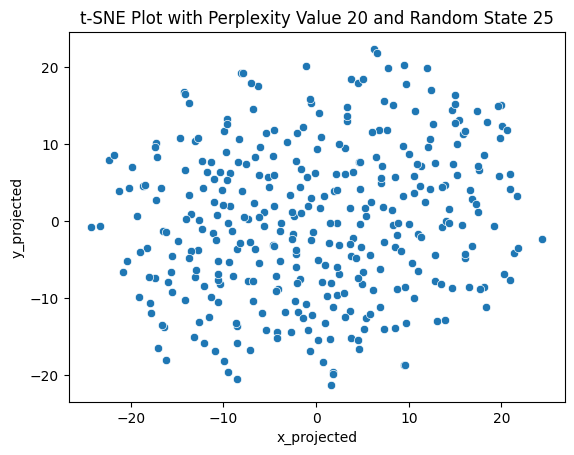

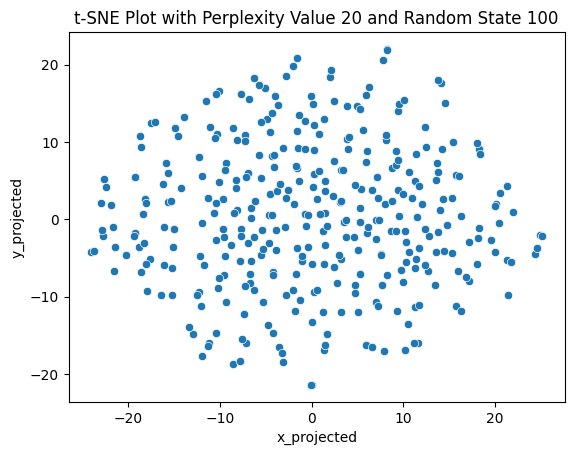

--------------------------------------------


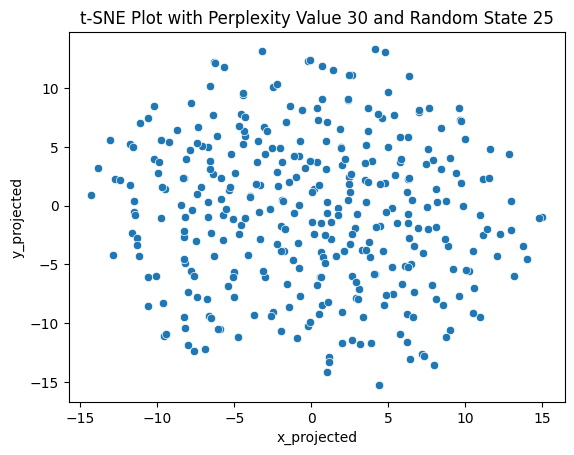

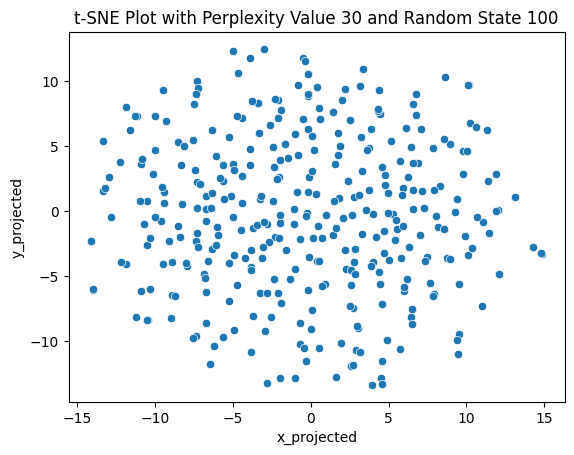

--------------------------------------------


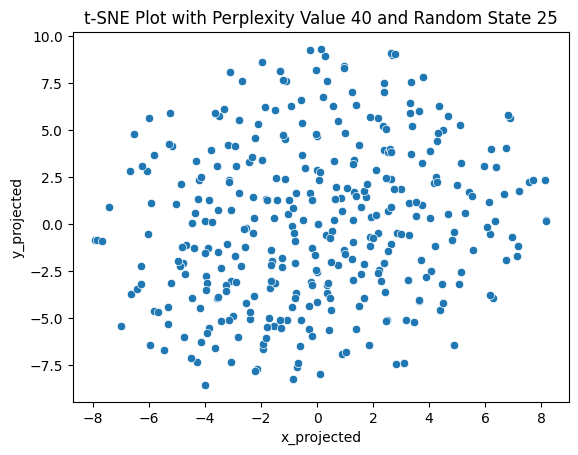

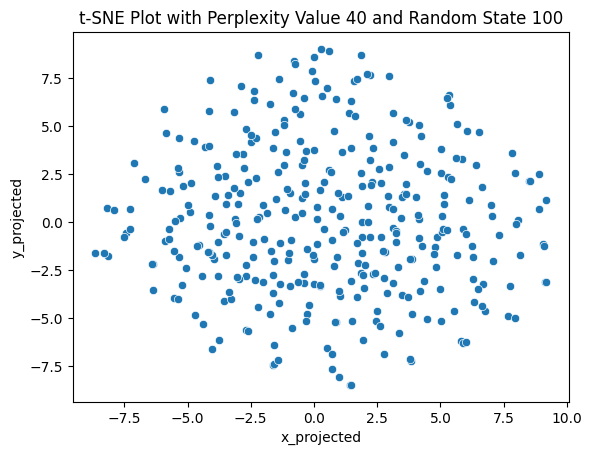

--------------------------------------------


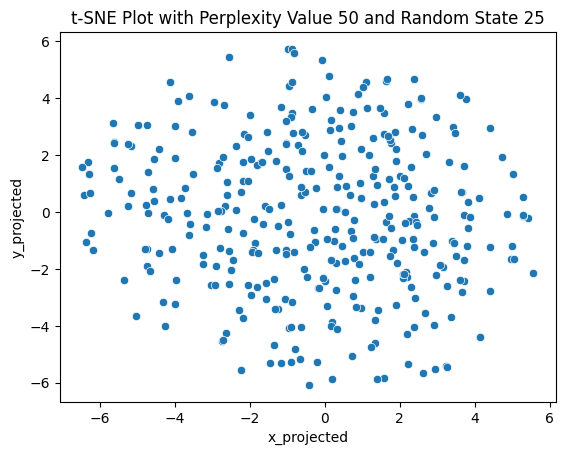

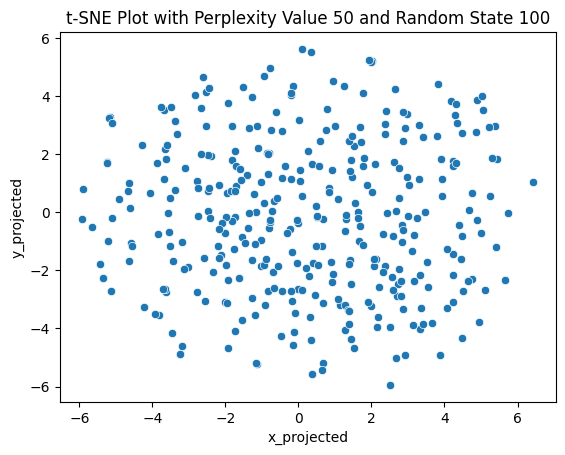

--------------------------------------------


In [30]:
from sklearn.manifold import TSNE
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [25, 100]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed', init='random')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([X_total, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

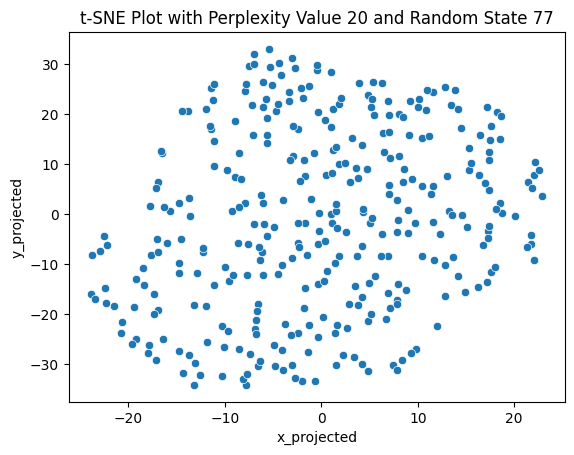

In [ ]:
tsne = TSNE(n_components=2, perplexity=20, random_state=77)
data_tsne = tsne.fit_transform(new_dist_mat)
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df_subset_outlier_removal, df_tsne], axis=1)
sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(20, 77))
plt.show()

In [ ]:
df_cat = df_subset_outlier_removal.select_dtypes(include = ['object'])


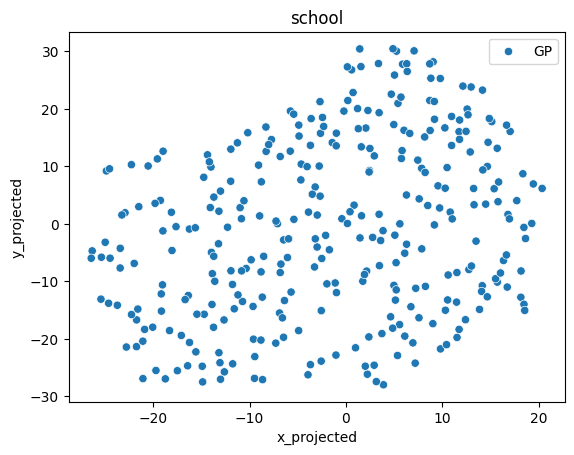

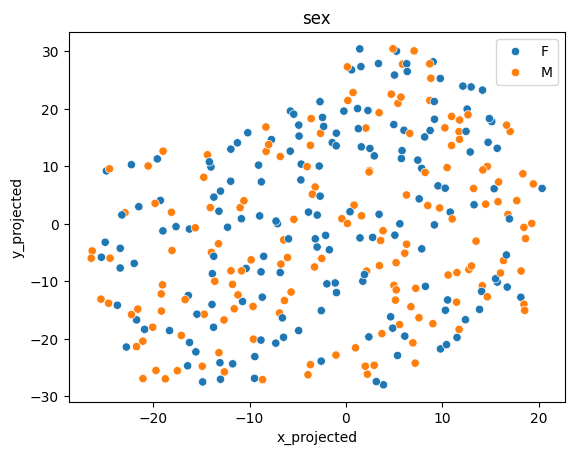

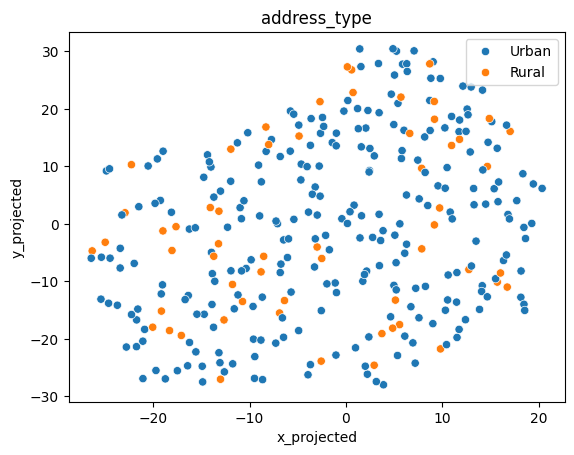

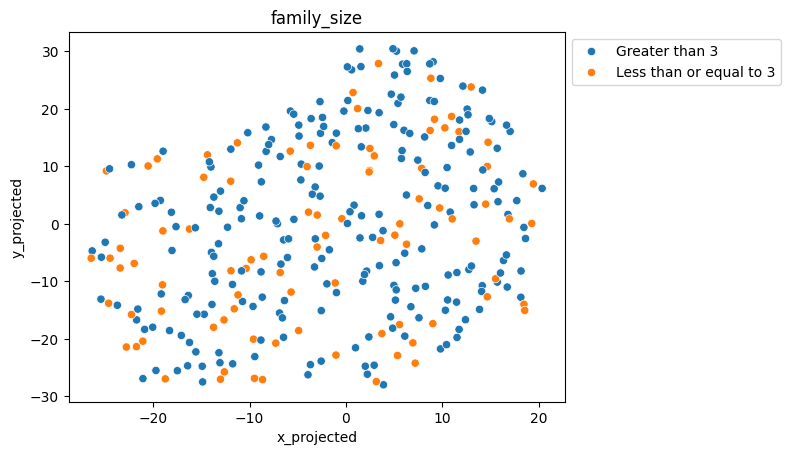

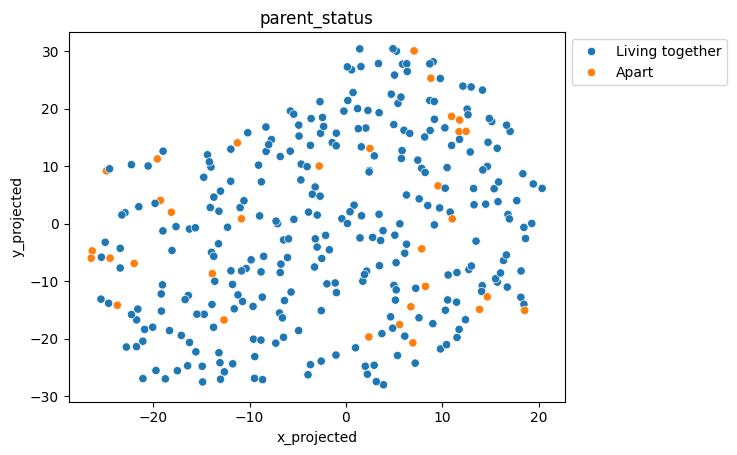

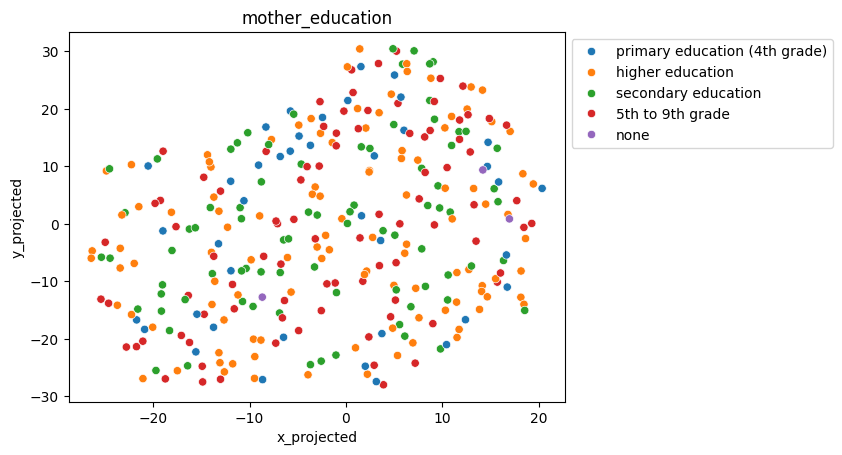

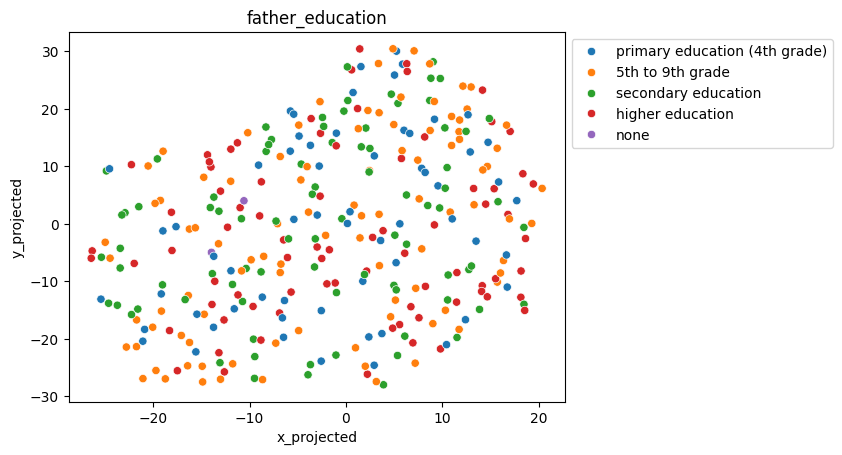

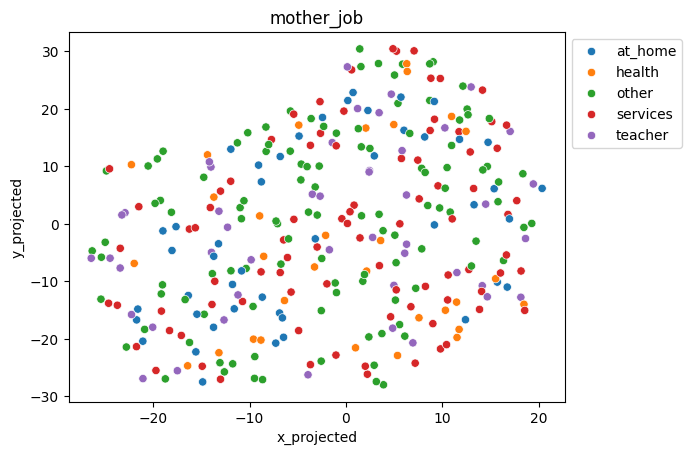

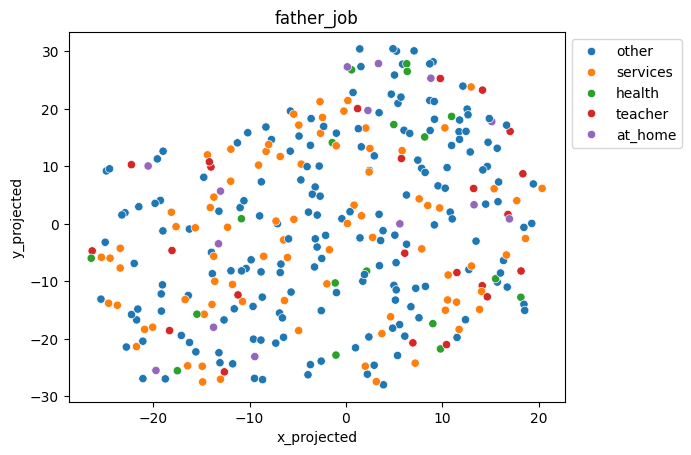

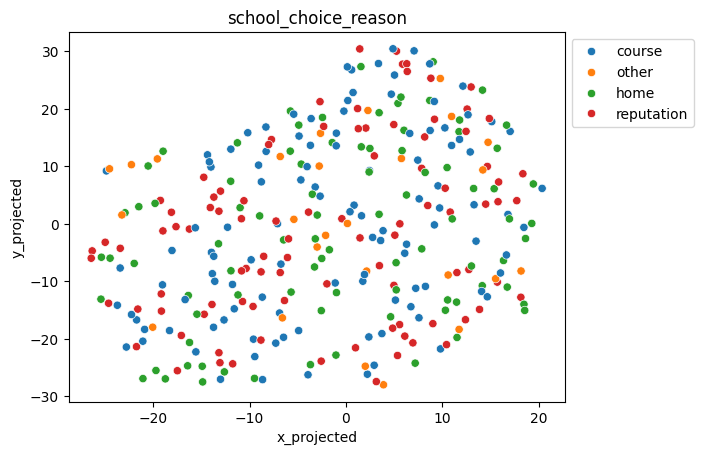

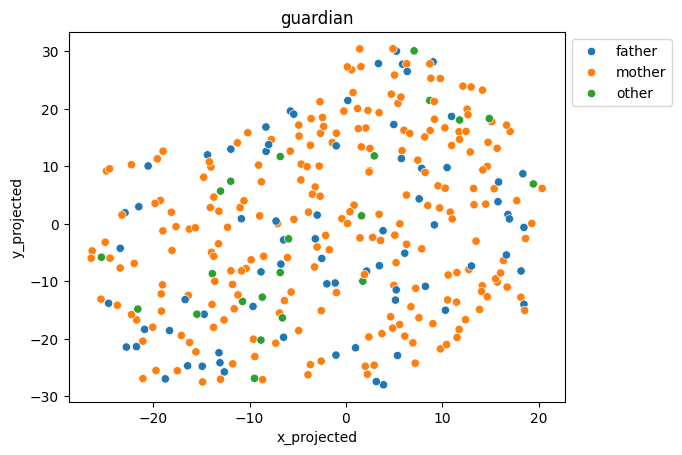

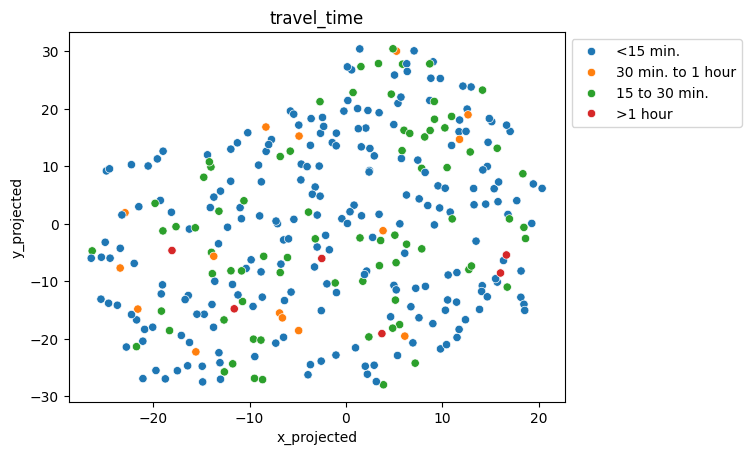

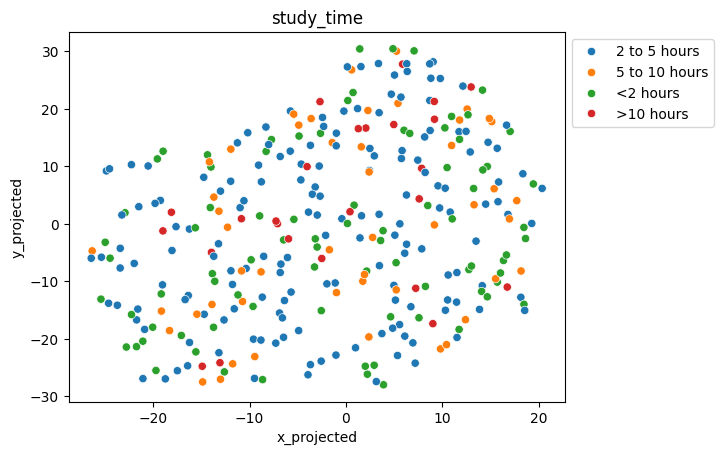

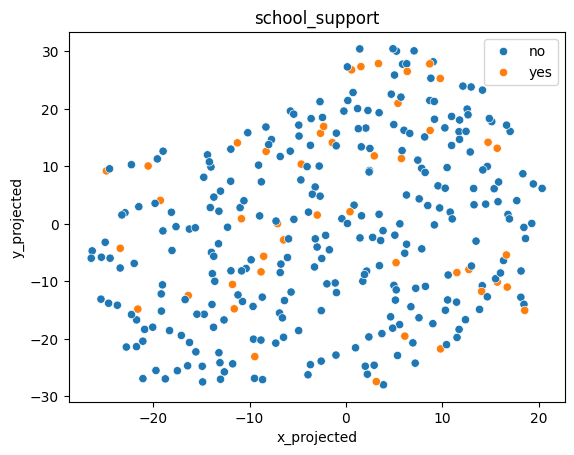

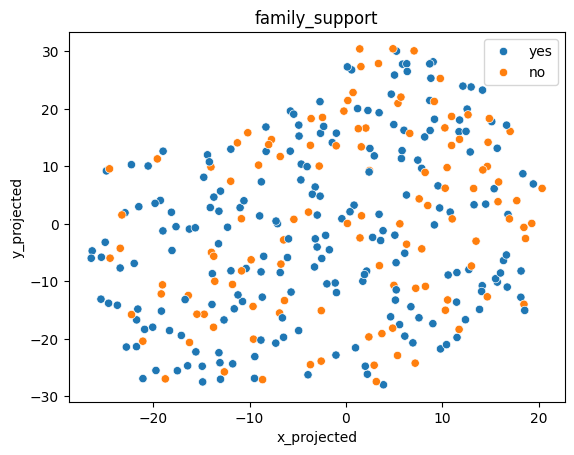

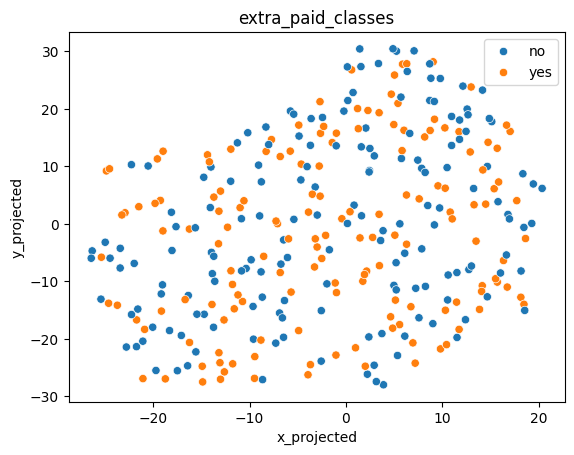

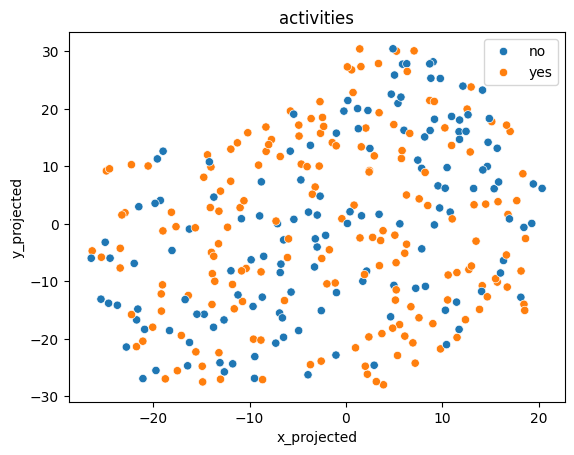

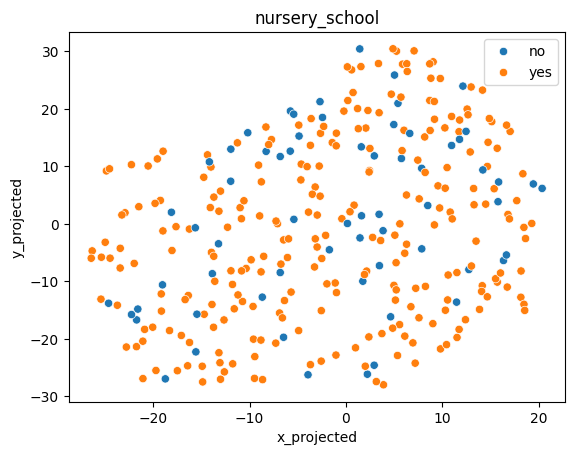

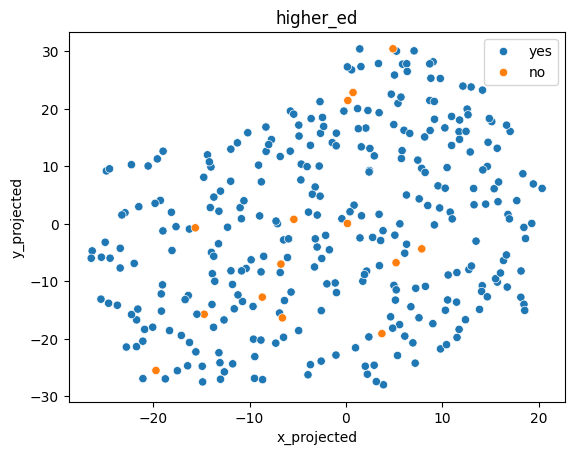

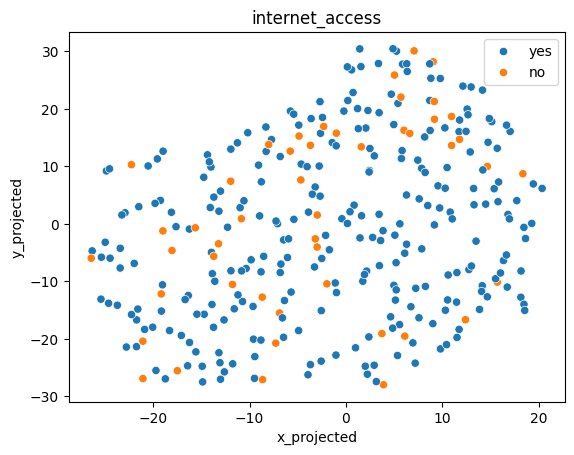

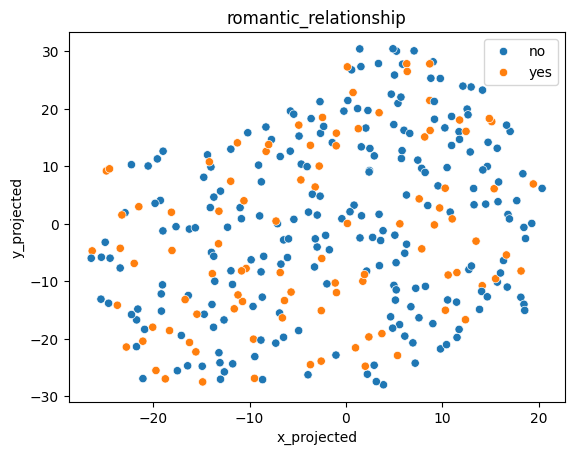

In [ ]:
for col in df_cat.columns:
    sns.scatterplot(x='x_projected', y='y_projected', hue=col, data=df_combo)
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

It looks like the higher_ed, extra_paid_class, family_support and sex have the strongest association with the clustering structure suggested by the t-SNE plots when using the Gower's distance matrix.

## 7. Clustering Algorithm Selection Motivation

## 8. Clustering Algorithm Practical Considerations

## 9. Clustering Algorithm #1



### Using Clustering Evaluation Metrics

To further help us select the best values for $\epsilon$ and $minpts$ in the DBSCAN algorithm, let's cluster this noisy dataset multiple times, each time using different parameter values. For each DBSCAN clustering we will evaluate the following metrics:
* average silhouette score
* Calinski-Harabazs score
* the number of noise points that DBSCAN identifies
* the number of clusters that DBSCAN identifies

In [ ]:
df_combo

student_id school  sex   age address_type              family_size  \
1           2.0     GP    F  17.0        Urban           Greater than 3   
2           3.0     GP    F  15.0        Urban  Less than or equal to 3   
3           4.0     GP    F  15.0        Urban           Greater than 3   
4           5.0     GP    F  16.0        Urban           Greater than 3   
5           6.0     GP    M  16.0        Urban  Less than or equal to 3   
..          ...    ...  ...   ...          ...                      ...   
150         NaN    NaN  NaN   NaN          NaN                      NaN   
154         NaN    NaN  NaN   NaN          NaN                      NaN   
269         NaN    NaN  NaN   NaN          NaN                      NaN   
307         NaN    NaN  NaN   NaN          NaN                      NaN   
333         NaN    NaN  NaN   NaN          NaN                      NaN   

       parent_status               mother_education  \
1    Living together  primary education (4th grade)   
2    Living together  primary education (4th grade)   
3    Living together               higher education   
4    Living together            secondary education   
5    Living together               higher education   
..               ...                            ...   
150              NaN                            NaN   
154              NaN                            NaN   
269              NaN                            NaN   
307              NaN                            NaN   
333              NaN                            NaN   

                  father_education mother_job  ... weekday_alcohol  \
1    primary education (4th grade)    at_home  ...             1.0   
2    primary education (4th grade)    at_home  ...             2.0   
3                 5th to 9th grade     health  ...             1.0   
4              secondary education      other  ...             1.0   
5              secondary education   services  ...             1.0   
..                             ...        ...  ...             ...   
150                            NaN        NaN  ...             NaN   
154                            NaN        NaN  ...             NaN   
269                            NaN        NaN  ...             NaN   
307                            NaN        NaN  ...             NaN   
333                            NaN        NaN  ...             NaN   

    weekend_alcohol health absences grade_1  grade_2 final_grade letter_grade  \
1               1.0    3.0      4.0     5.0      5.0         6.0            F   
2               3.0    3.0     10.0     7.0      8.0        10.0            C   
3               1.0    5.0      2.0    15.0     14.0        15.0            B   
4               2.0    5.0      4.0     6.0     10.0        10.0            C   
5               2.0    5.0     10.0    15.0     15.0        15.0            B   
..              ...    ...      ...     ...      ...         ...          ...   
150             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
154             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
269             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
307             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
333             NaN    NaN      NaN     NaN      NaN         NaN          NaN   

    x_projected y_projected  
1     -6.477333  -19.749886  
2     14.749122   14.163392  
3     -4.897426   17.152082  
4      9.048611   28.161669  
5     -0.425520    0.866123  
..          ...         ...  
150  -16.172012  -17.495258  
154  -18.723707  -14.358427  
269   -9.566363  -16.162022  
307   13.029449   10.629653  
333    6.868811   31.579243  

[349 rows x 37 columns]

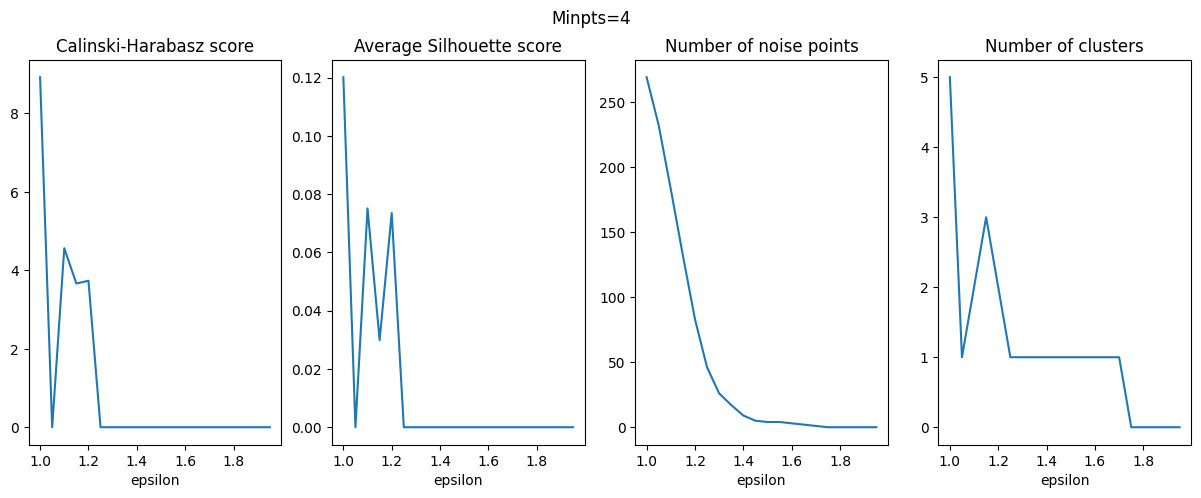

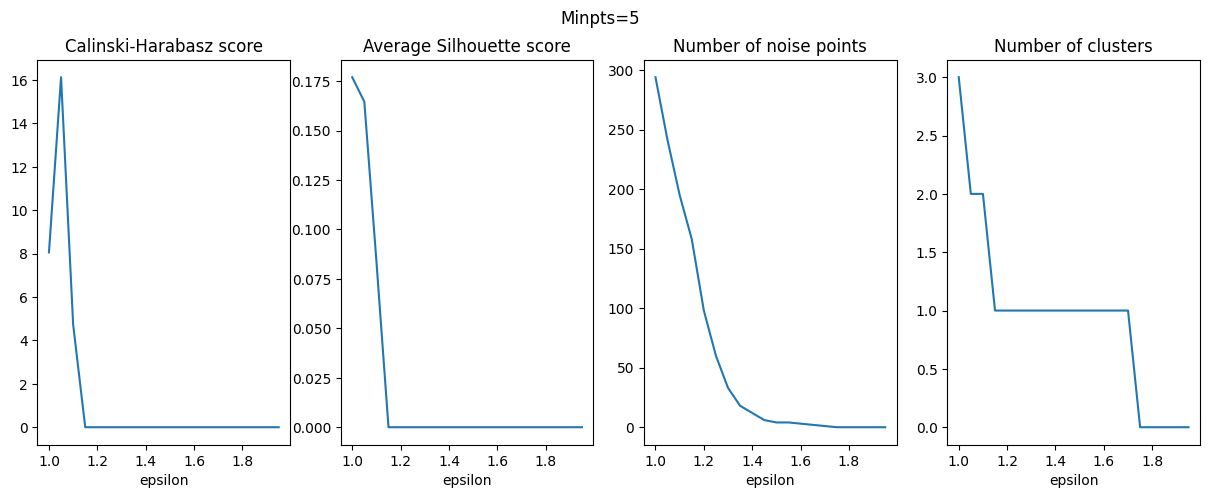

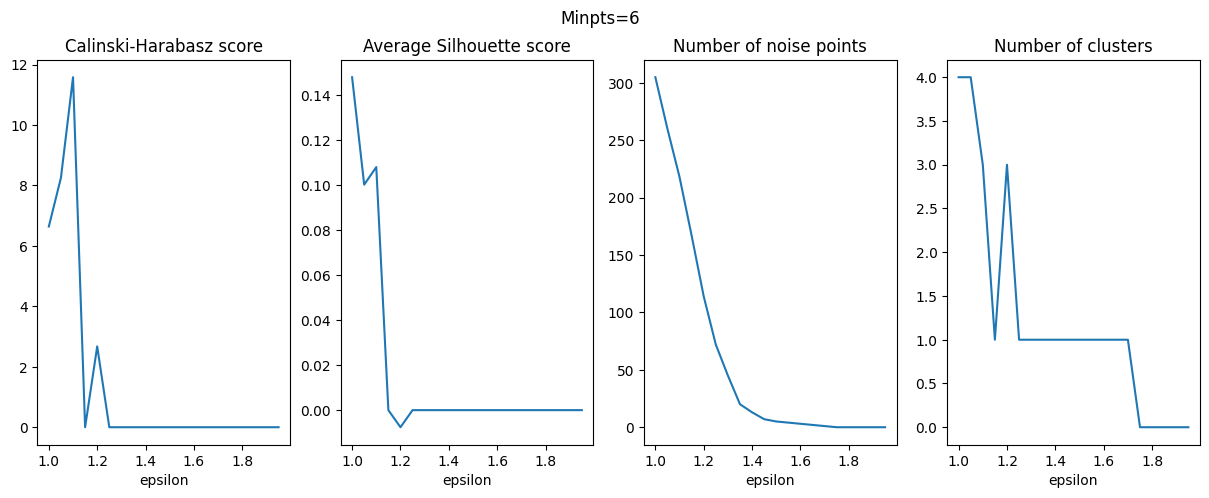

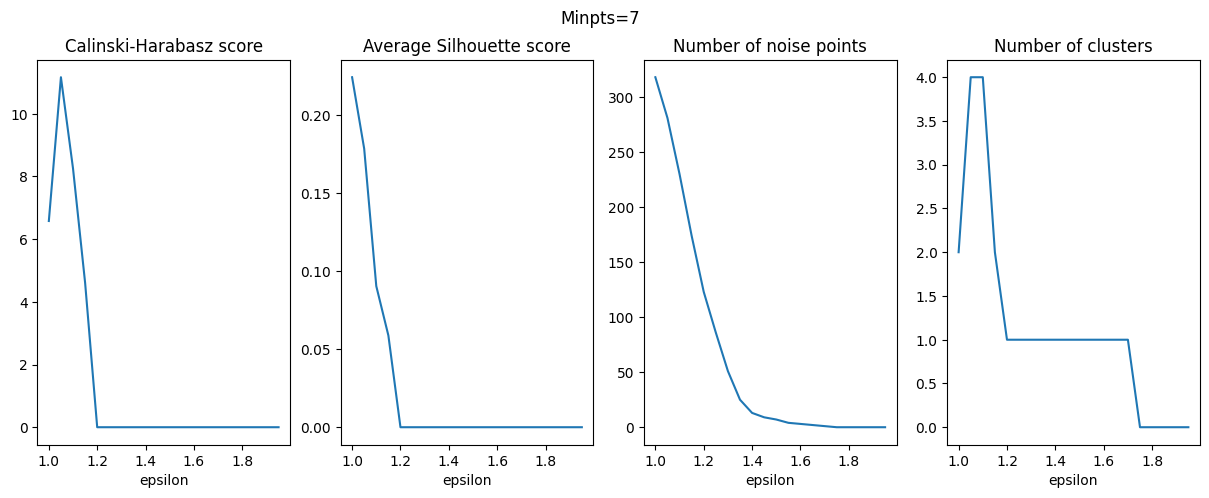

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Perform the preliminary analysis
for minpts in [4,5,6,7]:
    calinski_harabazs_scores = []
    silhouette_scores = []
    num_clusters = []
    num_noise_points = []


    num_clusters_p = []
    n_noise_points_p = []
    silhouette_scores_p = []
    calinski_harabazs_scores_p = []

    for eps in np.arange(1,2, 0.05):
        #Cluster the dataset using DBSCAN
        dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
        df_combo['predicted_cluster'] = dst.fit_predict(new_dist_mat)

        #Filter out the noise points
        df_noisy_no_noise=df_combo[df_combo['predicted_cluster']!=-1]
        
        #Get the number of clusters in the clustering
        k=len(df_combo['predicted_cluster'].value_counts())-1
        num_clusters.append(k)
        
        #Get the number of noise points
        noise_point_num=len(df_combo[df_combo['predicted_cluster']==-1])
        num_noise_points.append(noise_point_num)
        
        #Average silhouette score of the clustering
        if k>1:
            silhouette_scores.append(silhouette_score(new_dist_mat[df_combo['predicted_cluster']!=-1],
                                                              df_combo[df_combo['predicted_cluster']!=-1]['predicted_cluster']))
        else:
            #(If there is only one cluster, then the average silhouette score is 0)
            silhouette_scores.append(0)
        #Calinski-Harabasz score of the clsutering
        if k>1:
            calinski_harabazs_scores.append(calinski_harabasz_score(new_dist_mat[df_combo['predicted_cluster']!=-1],
                                                                        df_combo[df_combo['predicted_cluster']!=-1]['predicted_cluster']))
        else:
            calinski_harabazs_scores.append(0)
        
    # Show the results of the preliminary analysis
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharex=True)

    eps = np.arange( 1, 2,0.05)
    fig.suptitle('Minpts=%s'%minpts)
    ax[0].plot(eps, calinski_harabazs_scores)
    ax[1].plot(eps, silhouette_scores)    
    ax[2].plot(eps, num_noise_points)
    ax[3].plot(eps, num_clusters)

    ax[0].set_title('Calinski-Harabasz score')
    ax[1].set_title('Average Silhouette score')
    ax[2].set_title('Number of noise points')
    ax[3].set_title('Number of clusters')

    #ax[0].set_yticks(np.arange(5, 60, 7))
    ax[0].set_xlabel('epsilon')
    ax[1].set_xlabel('epsilon')
    ax[2].set_xlabel('epsilon')
    ax[3].set_xlabel('epsilon')
    plt.show()

plt.savefig('DBSCAN_preliminary.jpg', dpi=600)

In [ ]:
df_combo

student_id school  sex   age address_type              family_size  \
1           2.0     GP    F  17.0        Urban           Greater than 3   
2           3.0     GP    F  15.0        Urban  Less than or equal to 3   
3           4.0     GP    F  15.0        Urban           Greater than 3   
4           5.0     GP    F  16.0        Urban           Greater than 3   
5           6.0     GP    M  16.0        Urban  Less than or equal to 3   
..          ...    ...  ...   ...          ...                      ...   
150         NaN    NaN  NaN   NaN          NaN                      NaN   
154         NaN    NaN  NaN   NaN          NaN                      NaN   
269         NaN    NaN  NaN   NaN          NaN                      NaN   
307         NaN    NaN  NaN   NaN          NaN                      NaN   
333         NaN    NaN  NaN   NaN          NaN                      NaN   

       parent_status               mother_education  \
1    Living together  primary education (4th grade)   
2    Living together  primary education (4th grade)   
3    Living together               higher education   
4    Living together            secondary education   
5    Living together               higher education   
..               ...                            ...   
150              NaN                            NaN   
154              NaN                            NaN   
269              NaN                            NaN   
307              NaN                            NaN   
333              NaN                            NaN   

                  father_education mother_job  ... weekday_alcohol  \
1    primary education (4th grade)    at_home  ...             1.0   
2    primary education (4th grade)    at_home  ...             2.0   
3                 5th to 9th grade     health  ...             1.0   
4              secondary education      other  ...             1.0   
5              secondary education   services  ...             1.0   
..                             ...        ...  ...             ...   
150                            NaN        NaN  ...             NaN   
154                            NaN        NaN  ...             NaN   
269                            NaN        NaN  ...             NaN   
307                            NaN        NaN  ...             NaN   
333                            NaN        NaN  ...             NaN   

    weekend_alcohol health absences grade_1  grade_2 final_grade letter_grade  \
1               1.0    3.0      4.0     5.0      5.0         6.0            F   
2               3.0    3.0     10.0     7.0      8.0        10.0            C   
3               1.0    5.0      2.0    15.0     14.0        15.0            B   
4               2.0    5.0      4.0     6.0     10.0        10.0            C   
5               2.0    5.0     10.0    15.0     15.0        15.0            B   
..              ...    ...      ...     ...      ...         ...          ...   
150             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
154             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
269             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
307             NaN    NaN      NaN     NaN      NaN         NaN          NaN   
333             NaN    NaN      NaN     NaN      NaN         NaN          NaN   

    x_projected y_projected  
1     -6.477333  -19.749886  
2     14.749122   14.163392  
3     -4.897426   17.152082  
4      9.048611   28.161669  
5     -0.425520    0.866123  
..          ...         ...  
150  -16.172012  -17.495258  
154  -18.723707  -14.358427  
269   -9.566363  -16.162022  
307   13.029449   10.629653  
333    6.868811   31.579243  

[349 rows x 37 columns]

## 10. Clustering Algorithm #2

## 11. Discussion

## 12. Conclusion

## References